# Pangenome-Scale Metabolic Network Reconstruction Reveals a Diverse Genetic Basis for Metabolic Reactions

### Introduction

The reconstruction of metabolic networks at the pangenome scale offers profound insights into the genetic diversity and metabolic capabilities within microbial communities. In this study, we focus on *Escherichia coli* and apply a systematic approach to reconstruct genome-scale metabolic models (GEMs) across thousands of strains. This approach provides a detailed view of core, accessory, and rare metabolic reactions and their genetic basis, thereby revealing evolutionary patterns and niche-specific adaptations within the *E. coli* lineage.

### Objectives

This notebook is designed to reproduce the results and figures presented in the manuscript, with the primary objectives being to:
- Explore the distribution of core, accessory, and rare genes across the pangenome.
- Quantify the variation in neighboring genes and genomic locations across metabolic reactions.
- Investigate the association between rare genes and specific phylons.
- Validate the reconstructed models against experimental data using Biolog phenotyping.

### Methodology

We utilize a range of computational tools to analyze thousands of *E. coli* strains, starting with the identification of core and accessory genes, followed by gene neighborhood analysis, reaction clustering, and validation against phenotyping data. This notebook will walk through the process, starting from data preprocessing and progressing through the calculations, visualizations, and statistical analyses needed to regenerate the results and figures in the manuscript.

---

### How to Use This Notebook

Each section in the notebook includes code cells and instructions to regenerate the results. Simply execute each cell in sequence to reproduce the analyses and figures. For questions or modifications, comments are provided to guide you through adapting the analyses to other datasets or parameters.

**Note:** The analyses in this notebook are computationally intensive; it is recommended to use a high-performance computational environment, ideally with multiple cores.

### Author

- Omid Ardalani

---

### References

- [Under submission]

---

Happy analyzing!


### Draft GEMs recosntruction

In [ ]:
# Pangenome-Scale GEM Reconstruction and Curation for E. coli

# Import required scripts for GEM reconstruction and curation
# (Ensure the scripts are in the same directory as this notebook or update paths accordingly)
import add_missed_reactions_ecoli
import Eco_panGEM_curation
import add_spont_to_gems_ecoli4

# Define necessary inputs
"""
Before proceeding, ensure the following inputs are prepared:

1. **ref_model_dir**: Directory of the reference model in .mat format, serving as the template model.
2. **prots_dir**: Protein FASTA file containing all genes within the template model or the complete reactome.
3. **nucls_dir**: Nucleotide FASTA file of all genes within the template model or the complete reactome.
4. **target_genome_dir**: Directory of target genomes in .gbk format.

With these inputs, you can run the panGEM pipeline as follows:
"""
# please reference our previous work if you use pangem.py to generate draft models (https://journals.asm.org/doi/10.1128/msystems.00156-24)
# Run the panGEM pipeline 
!pangem.py 

### Add missing genes and their corresponding reaction

In [ ]:
# find missing locustags
!gems_missing_genes.py

# preparing missing locus tags
!miss_locci_df_preparation.py

# formulate reactions for missing locustags
!gems_missing_reactions_kegg.py

### processing the missing reactions data to formulate GPRs

In [9]:
# ## Notebook 2: Missed Reactions Curation and Mapping
# This notebook processes and maps missing reactions in E. coli metabolic models, preparing input data for further curation and analysis.

# ### Import Required Libraries
import pandas as pd
import re
from Bio.KEGG import REST
import json

# ### 1. Load and Clean Input Data
# Load the necessary datasets containing missed reactions and tidy annotations.

# Load datasets
#run below command in terminal to download the BiGG universal model
# !wget http://bigg.ucsd.edu/static/namespace/universal_model.json

# the rest of the data
missre = pd.read_csv('/Users/omidard/Data/files/ecoli_missed_reactions_refined.csv')
tidy = pd.read_csv('/Users/omidard/Data/files/tidy_missing_locci_ecoli.csv')

# Remove extraneous characters and null values from key columns
missre['EC_Number'] = missre['EC_Number'].str.replace(']', '', regex=False)
missre = missre.dropna(subset=['Reaction'])
tidy['protein'] = tidy['protein'].str.replace(']', '', regex=False)

# Merge data on protein names to get a combined DataFrame for missed reactions
missed_reaction_database = pd.merge(tidy, missre, left_on='protein', right_on='Protein_Name', how='inner')
missed_reaction_database.fillna('Not Found', inplace=True)

# ### 2. Extract and Curate Reaction IDs
# Extract reaction IDs from the 'All_Reac' column and clean up entries.

# Define function to clean and extract reaction IDs
def curate_list(entry):
    entry = re.sub(r'[>;\'"(other)]', '', entry)
    reactions = re.findall(r"R\d{5}(?:\(G\))?", entry)
    reactions = list(set([r.replace('(G)', '') for r in reactions]))  # Deduplicate
    return reactions

# Apply the curation function
curated_short_list = missed_reaction_database['All_Reac'].unique()
curated_short_list = [curate_list(entry) for entry in curated_short_list]
flattened_list = [item for sublist in curated_short_list for item in sublist]

# ### 3. Retrieve and Map Reaction Details from KEGG
# Retrieve reaction details, such as equations and pathways, using the KEGG REST API.

def extract_details(reaction_id):
    result = REST.kegg_get(reaction_id).read()
    equation, pathway = "", ""
    reading_equation, reading_pathway = False, False
    for line in result.split("\n"):
        if line.startswith("EQUATION"):
            reading_equation = True
            equation = line.split("EQUATION")[1].strip()
        elif line.startswith("PATHWAY"):
            reading_pathway = True
            pathway = line.split("PATHWAY")[1].strip()
        elif reading_equation and not line.startswith(" "):
            reading_equation = False
        elif reading_pathway and not line.startswith(" "):
            reading_pathway = False
        elif reading_equation:
            equation += " " + line.strip()
        elif reading_pathway:
            pathway += " " + line.strip()
    return equation, pathway

# Collect equations and pathways for each reaction
data = [[reaction_id, *extract_details(reaction_id)] for reaction_id in flattened_list]
kegg = pd.DataFrame(data, columns=["reaction_id", "equation", "pathway"])

# ### 4. Map KEGG to ModelSEED and BiGG IDs
# Load ModelSEED reaction aliases and map KEGG IDs to BiGG IDs, preparing for integration with GEMs.

# Load ModelSEED Aliases and BiGG mappings
seed = pd.read_csv('/Users/omidard/Data/files/Unique_ModelSEED_Reaction_Aliases.txt', sep='\t')

# Map SEED_ID and BiGG_ID for each reaction
result_df = kegg.copy()
result_df['SEED_ID'], result_df['BiGG_ID'] = None, None
grouped = seed.groupby('ModelSEED ID')
for seed_id, group in grouped:
    matching_rows = group[group['External ID'].isin(result_df['reaction_id'])]
    if not matching_rows.empty:
        result_df.loc[result_df['reaction_id'].isin(matching_rows['External ID']), 'SEED_ID'] = seed_id
        bigg_ids = matching_rows.loc[matching_rows['Source'] == 'BiGG', 'External ID'].tolist()
        if bigg_ids:
            result_df.loc[result_df['reaction_id'].isin(matching_rows['External ID']), 'BiGG_ID'] = ', '.join(bigg_ids)

# ### 5. Replace Metabolites with BIGG IDs in Reaction Equations
# Replace KEGG metabolites in reaction equations with corresponding BIGG metabolites for compatibility.

# Load universal model metabolites
with open('/Users/omidard/Desktop/universal_model.json', 'r') as file:
    metabolites = json.load(file)['metabolites']

# Build dictionary mapping KEGG compounds to BiGG IDs
filtered_metabolites = []
for met in metabolites:
    if 'annotation' in met:
        # Find KEGG Compound annotations and ensure `ann` is a string
        kegg_compounds = [ann.split('/')[-1] for ann in met['annotation'] if isinstance(ann, str) and 'KEGG Compound' in ann]
        if kegg_compounds:
            # Take the first KEGG ID if multiple are found
            filtered_metabolites.append([met['id'], kegg_compounds[0]])

# Convert to DataFrame and create a mapping dictionary
bigg_df = pd.DataFrame(filtered_metabolites, columns=["met_id", "kegg_compound"]).drop_duplicates()
kegg_to_bigg_mapping = dict(zip(bigg_df['kegg_compound'], bigg_df['met_id']))

# Define a function to replace KEGG compounds in the reaction equations with BiGG IDs
def replace_with_met_id(equation):
    compounds = equation.split()
    for i, compound in enumerate(compounds):
        if compound.startswith('C') and compound in kegg_to_bigg_mapping:
            compounds[i] = kegg_to_bigg_mapping[compound] + "_c"
    return ' '.join(compounds)

# Replace KEGG compounds in reaction equations
kegg['curated_reaction'] = kegg['equation'].apply(replace_with_met_id)

# ### 6. Generate Final Merged DataFrame for Analysis
# Map KEGG IDs to `missed_reaction_database` and merge with KEGG data to generate `merged_df`.

# Remove unnecessary characters and create a list for 'All_Reac' reactions
missed_reaction_database['All_Reac'] = missed_reaction_database['All_Reac'].str.replace("']", '', regex=False).str.replace("['", '', regex=False)
missed_reaction_database['All_Reac_List'] = missed_reaction_database['All_Reac'].str.split(', ')
missed_reaction_database['All_Reac_List'] = missed_reaction_database['All_Reac_List'].apply(lambda x: [item for item in x if item.startswith('R')])

# Explode DataFrame by reaction list for accurate mapping
exploded_df = missed_reaction_database.explode('All_Reac_List')
merged_df = exploded_df.merge(kegg, left_on='All_Reac_List', right_on='reaction_id', how='left')

# Rename columns and drop unnecessary ones
merged_df = merged_df.rename(columns={'equation': 'Curated_Reaction'})
cols_to_drop = ['All_Reac_List', 'reaction_id', 'EC_Number', 'Protein_Name', 'All_Reac']
merged_df = merged_df.drop(columns=[col for col in cols_to_drop if col in merged_df.columns])

# Save the `merged_df` for further analysis
merged_df.to_csv('/Users/omidard/Desktop/merged_dfxxx.csv', index=False)
merged_df

model_id   missing_locus  gene locus_tag  \
0       562.16430.json  JFKNFMDL_00046  pdeD     b1815   
1       562.16430.json  JFKNFMDL_00226  gstA     b1635   
2       562.16430.json  JFKNFMDL_00275  ynfE     b1587   
3       562.30285.json  MFEIHMGG_00151  gstB     b0838   
4       562.30285.json  MFEIHMGG_00156  pdeI     b0833   
...                ...             ...   ...       ...   
346831  562.28307.json  HMEHPMLN_04902  rcsD     b2216   
346832  562.28307.json  HMEHPMLN_04913  napA     b2206   
346833  562.28307.json  HMEHPMLN_05011  pdeN     b2176   
346834  562.28307.json  HMEHPMLN_05126  dgcE     b2067   
346835  562.28307.json  HMEHPMLN_05154  galF     b2042   

                            db_xref  \
0       UniProtKB/Swiss-Prot:P76261   
1       UniProtKB/Swiss-Prot:P0A9D2   
2       UniProtKB/Swiss-Prot:P77374   
3       UniProtKB/Swiss-Prot:P0ACA7   
4       UniProtKB/Swiss-Prot:P75800   
...                             ...   
346831  UniProtKB/Swiss-Prot:P39838   
346832  UniProtKB/Swiss-Prot:P33937   
346833  UniProtKB/Swiss-Prot:P76446   
346834  UniProtKB/Swiss-Prot:P38097   
346835  UniProtKB/Swiss-Prot:P0AAB6   

                                                  protein   protein_id  \
0                putative c-di-GMP phosphodiesterase PdeD  NP_416329.4   
1                          glutathione S-transferase GstA  NP_416152.1   
2                        putative selenate reductase YnfE  NP_416104.1   
3                          glutathione S-transferase GstB  NP_415359.4   
4                putative c-di-GMP phosphodiesterase PdeI  NP_415354.1   
...                                                   ...          ...   
346831                            RcsD phosphotransferase  NP_416720.1   
346832         periplasmic nitrate reductase subunit NapA  NP_416710.1   
346833           putative c-di-GMP phosphodiesterase PdeN  NP_416681.1   
346834                  putative diguanylate cyclase DgcE  NP_416571.1   
346835  UTP:glucose-1-phosphate uridylyltransferase, l...  NP_416546.1   

                             location gbkey     pseudo  exception  \
0                    1898427..1900025   CDS  Not Found  Not Found   
1                    1714377..1714982   CDS  Not Found  Not Found   
2                    1658069..1660495   CDS  Not Found  Not Found   
3          complement(879854..880480)   CDS  Not Found  Not Found   
4                      872979..875327   CDS  Not Found  Not Found   
...                               ...   ...        ...        ...   
346831               2313488..2316160   CDS  Not Found  Not Found   
346832  complement(2300267..2302 753)   CDS  Not Found  Not Found   
346833               2270726..2272282   CDS  Not Found  Not Found   
346834               2143266..2146583   CDS  Not Found  Not Found   
346835  complement(2113434..2114 327)   CDS  Not Found  Not Found   

       transl_except    KEGG_ID  \
0          Not Found  eco:b1815   
1          Not Found   hsa:2938   
2          Not Found  eco:b1587   
3          Not Found   hsa:2947   
4          Not Found  eco:b0833   
...              ...        ...   
346831     Not Found  eco:b2216   
346832     Not Found  eco:b2206   
346833     Not Found  eco:b2176   
346834     Not Found  eco:b2067   
346835     Not Found  eco:b2042   

                                                    Class  \
0       Hydrolases;             Acting on ester bonds;...   
1       Transferases;             Transferring alkyl o...   
2       Oxidoreductases;             Other oxidoreduct...   
3       Transferases;             Transferring alkyl o...   
4       Hydrolases;             Acting on ester bonds;...   
...                                                   ...   
346831  Transferases;             Transferring phospho...   
346832  Oxidoreductases;             Acting on a heme ...   
346833  Hydrolases;             Acting on ester bonds;...   
346834  Transferases;             Transferring phospho...   
346835  Transferases;             Tran

# Manual curation step.
---

refine the final df by going through reactions.
Reaction IDs,
Met IDs
Equation (Directionality)

1- note: some genes can be added to alredy existing reaction in the GEMs, check to avoid redundancy
2- note: some reactions can be found in BiGG database, update the reaction information accorfingly
3- note: some reactions do not exist in BiGG database : a) we can find metabolites information for such reactions in BiGG database to formulate the equation. (check the directionality of these reactions in Ecocyc - Biocyc)
4- note: some reactions do not exist in BiGG database and also their metabolites can't be found in BiGG, formulate the GPRs from scratch.
5- note: see Cobrapy documentation for making a new reaction. (https://cobrapy.readthedocs.io/en/latest/building_model.html)

In [ ]:

# Add any missed reactions to draft GEMs 
!add_missed_reactions_ecoli.py


### Gapfilling

In [ ]:
# Perform gap-filling to complete draft models for target genomes (uncomment to execute)
!ecoli_gapfilling6.py

### Refinement

In [ ]:
# Add spontaneous reactions to draft GEMs for completion (uncomment to execute)
!add_spont_to_gems_ecoli4.py

### Curation

In [ ]:
# Run GEMs curation code
!Eco_panGEM_curation.py

### GEMs are curated, gapfilled and refined -- start validation

### Validation

In [15]:
# Load the biolog data (Biolog phenotyping result)
import pandas as pd
biolog_df_path = "/Users/omidard/Desktop/biolog.csv"
biolog = pd.read_csv(biolog_df_path)

In [ ]:
#run the validation script to add predictions to the biolog dataframe
!biolog_ecoli_prediction.py

In [16]:
biolog_df_path = "/Users/omidard/Desktop/biolog_data_with_prediction.csv"
biolog_data_with_predictions = pd.read_csv(biolog_df_path)

In [17]:
import pandas as pd
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(biolog_data_with_predictions['Growth'], biolog_data_with_predictions['Prediction'])
cm

array([[3313,   68],
       [  34, 1596]])

In [18]:
from sklearn.metrics import classification_report
report = classification_report(biolog_data_with_predictions['Growth'], biolog_data_with_predictions['Prediction'])
print(report)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      3381
         1.0       0.96      0.98      0.97      1630

    accuracy                           0.98      5011
   macro avg       0.97      0.98      0.98      5011
weighted avg       0.98      0.98      0.98      5011



/var/folders/g4/gzd2bm953vs0rn_qkz4wyd1w0000gp/T/ipykernel_25977/3879345046.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_averages = df.groupby('Metric').apply(lambda x: np.average(x['Score'], weights=x['Support']))


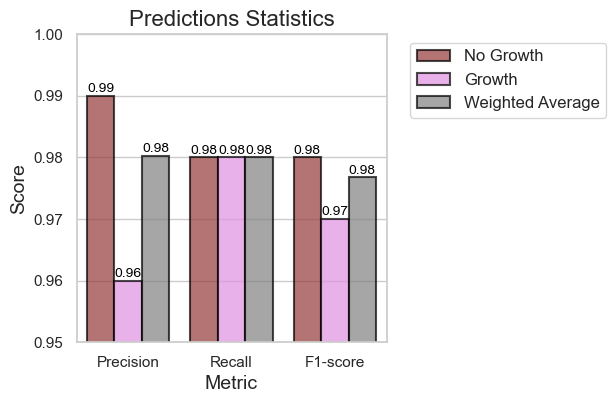

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data from your classification report
data = {
    "Metric": ["Precision", "Recall", "F1-score"] * 2,
    "Score": [0.99, 0.98, 0.98, 0.96, 0.98, 0.97],
    "Class": ["No Growth", "No Growth", "No Growth",
              "Growth", "Growth", "Growth"],
    "Support": [3381, 3381, 3381, 1630, 1630, 1630]  # Actual support numbers
}

df = pd.DataFrame(data)

# Compute weighted averages for each metric
weighted_averages = df.groupby('Metric').apply(lambda x: np.average(x['Score'], weights=x['Support']))
weighted_averages = weighted_averages.reset_index().rename(columns={0: 'Score'})
weighted_averages['Class'] = 'Weighted Average'

# Concatenate the original dataframe with the weighted averages
df = pd.concat([df, weighted_averages], ignore_index=True)

# Custom colors for the classes
custom_palette = {'No Growth': 'brown', 'Growth': 'violet', 'Weighted Average': 'gray'}

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Creating the bar plot
plt.figure(figsize=(4, 4))
barplot = sns.barplot(x="Metric", y="Score", hue="Class", data=df, palette=custom_palette, linewidth=1.5, edgecolor="black",alpha=0.7)

# Adding titles and labels
plt.title('Predictions Statistics', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Metric', fontsize=14)

# Enhancing legibility
plt.ylim(0.95, 1.0)  # Adjust y-axis limits to better show differences
plt.legend( title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate each bar with the respective data value
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     size=10, xytext = (0, 5), 
                     textcoords = 'offset points', color='black')

# Display the plot
#plt.savefig('/Users/omidard/Desktop/Stats_confusion.svg', dpi=300, bbox_inches='tight')
plt.show()

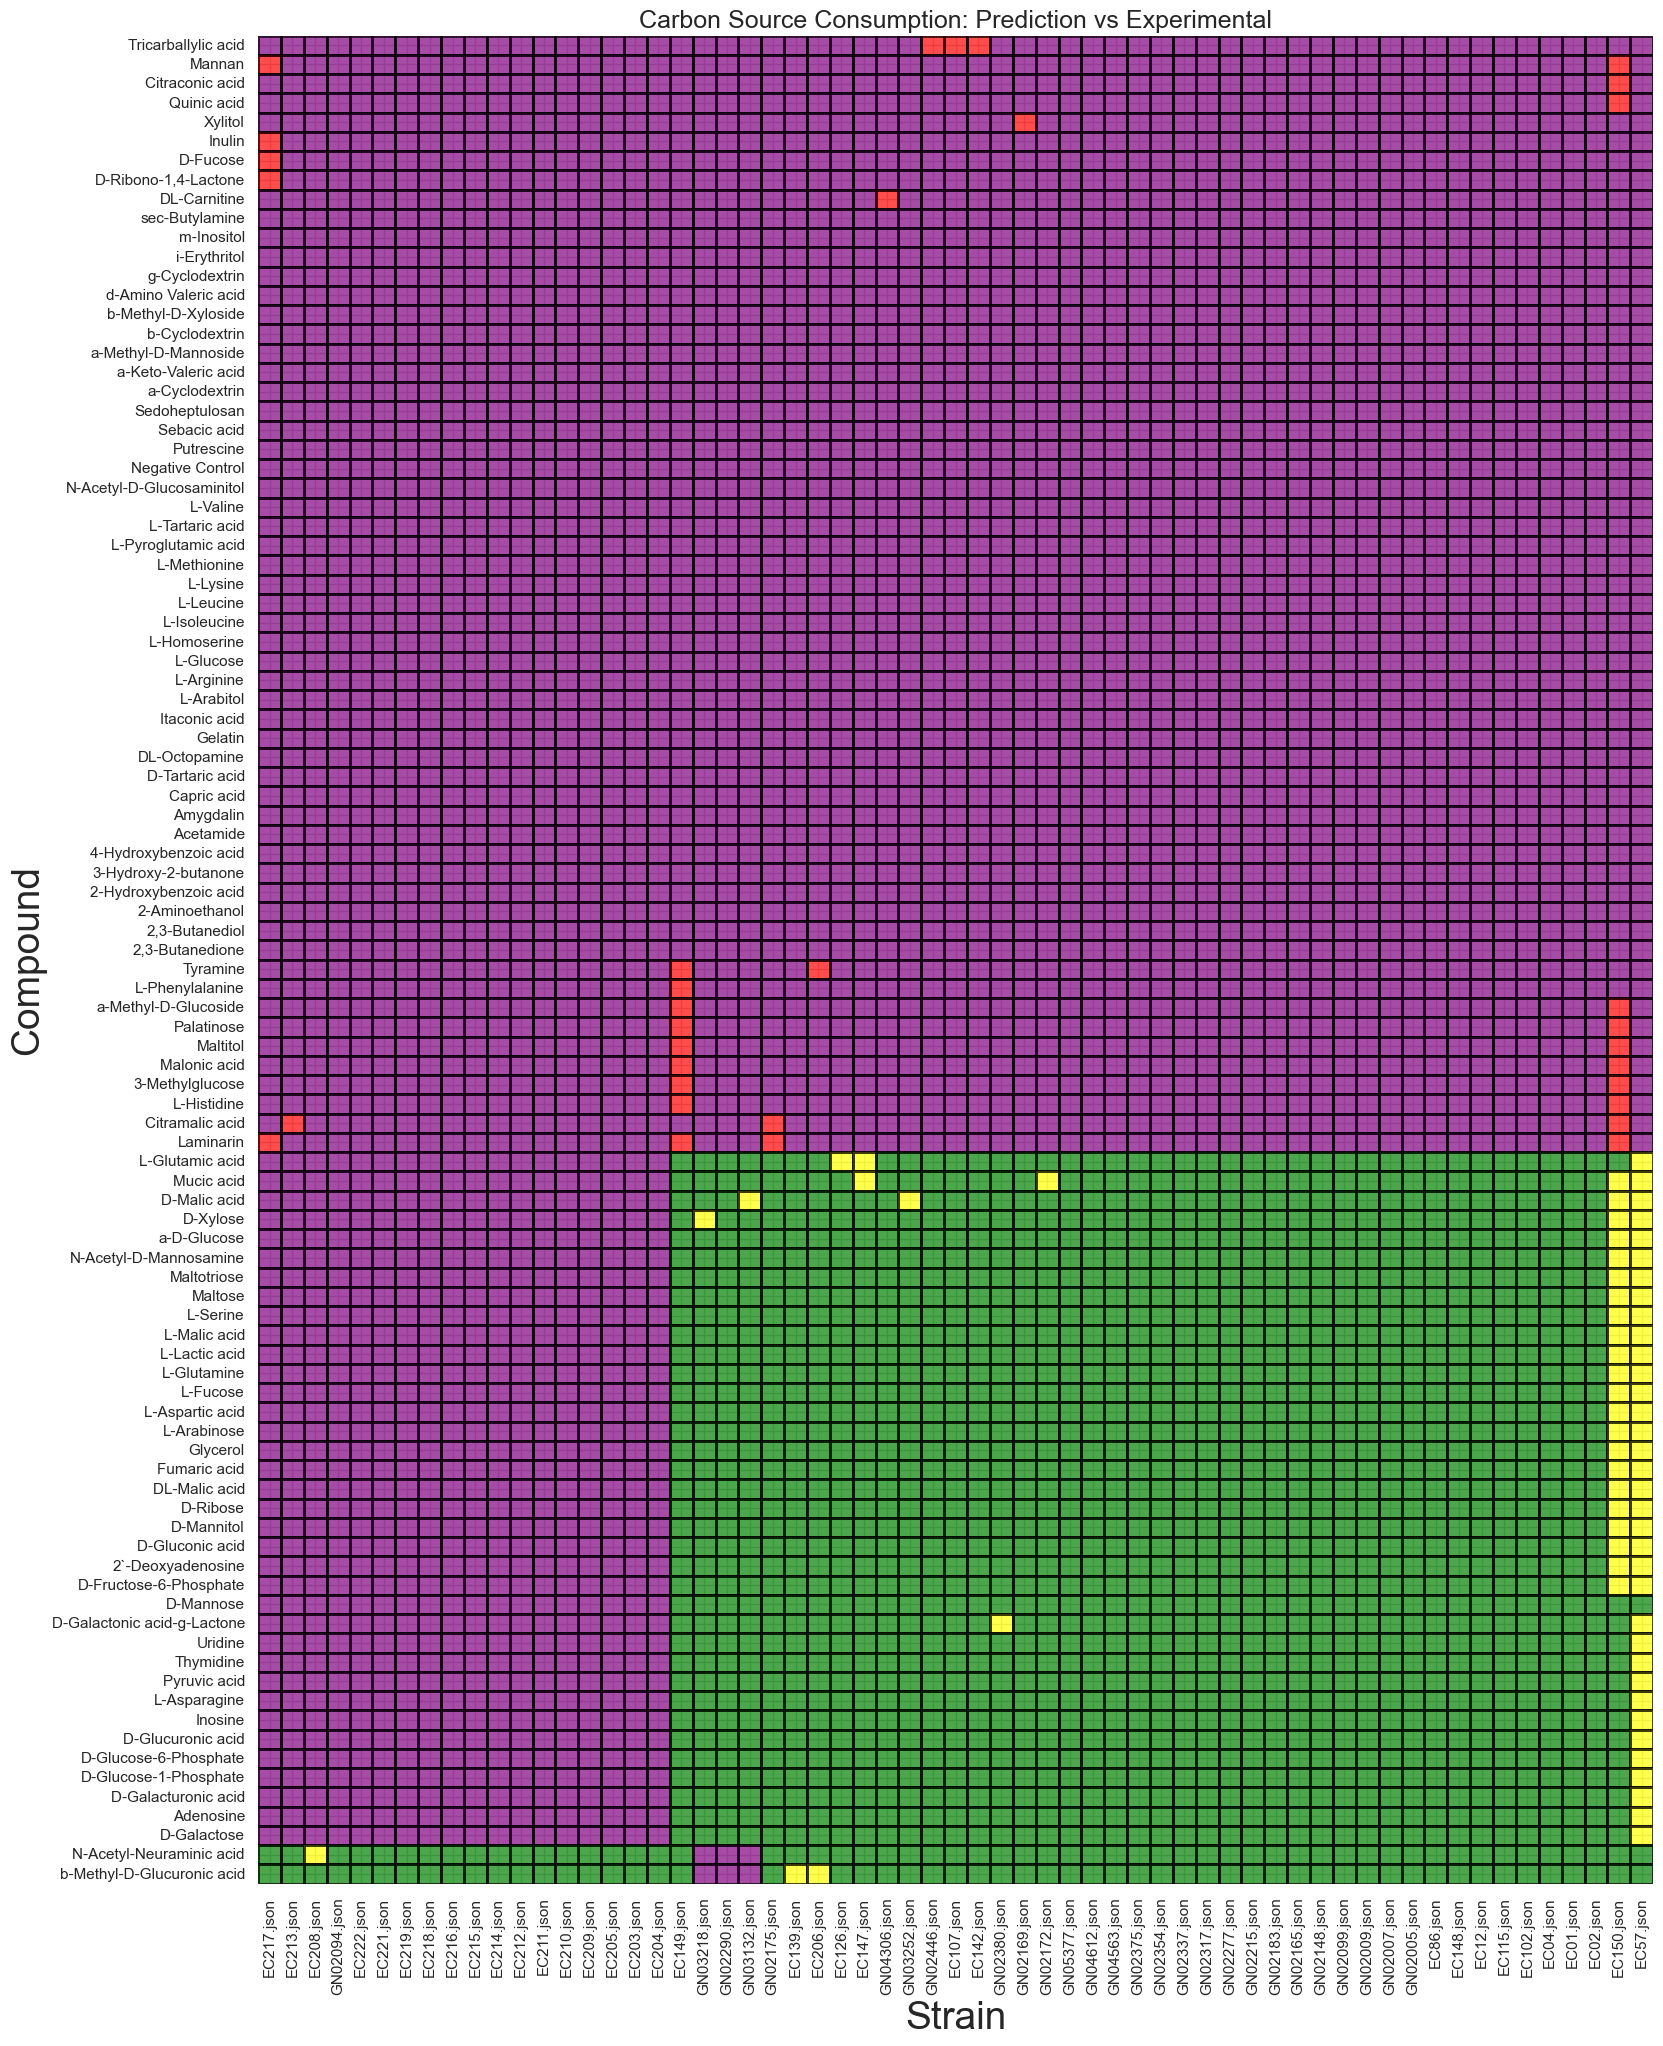

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import numpy as np
import matplotlib
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform
from matplotlib.cm import ScalarMappable


# Assuming pass_ess is your DataFrame and is already loaded
matplotlib.rcParams.update({'font.size': 12})

# Assuming biolog_df_m9_filtered is loaded and contains the necessary columns

# Step 1: Identify the outcomes
def classify_outcome(row):
    if row['Growth'] == row['Prediction']:
        return 0 if row['Growth'] == 0 else 3  # 0: TN, 3: TP
    else:
        return 1 if row['Growth'] == 0 else 2  # 1: FP, 2: FN

biolog_data_with_predictions['Outcome'] = biolog_data_with_predictions.apply(classify_outcome, axis=1)

# Step 2: Pivot the DataFrame
heatmap_data = biolog_data_with_predictions.pivot_table(index='Compound', columns='Strain', values='Outcome', aggfunc='first', fill_value=0)

# Step 3: Create a custom colormap
cmap = ListedColormap(['purple', 'yellow', 'red', 'green'])
bounds = [0, 1, 2, 3, 4]
norm = Normalize(vmin=0, vmax=3)

# Calculate the pairwise distances and linkage
row_linkage = linkage(pdist(heatmap_data, metric='hamming'), method='average')
col_linkage = linkage(pdist(heatmap_data.T, metric='hamming'), method='average')

# Reorder rows and columns according to the clustering
heatmap_data = heatmap_data.iloc[leaves_list(row_linkage), :]
heatmap_data = heatmap_data.iloc[:, leaves_list(col_linkage)]

# Now plot using the original heatmap approach
plt.figure(figsize=(18, 24))
ax = sns.heatmap(heatmap_data, cmap=cmap, norm=norm, cbar=False, alpha=0.7, linewidth=0.9, linecolor='black')

# Rest of the plotting code as above
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#colorbar = plt.colorbar(sm, ticks=[0.375, 1.125, 1.875, 2.625])
#colorbar.set_ticklabels(['True Negative', 'False Positive', 'False Negative', 'True Positive'], fontsize=18)
plt.title('Carbon Source Consumption: Prediction vs Experimental', fontsize=18)
plt.xlabel('Strain', fontsize=28)
#plt.xticks([])
plt.ylabel('Compound', fontsize=28)
#plt.savefig('/Users/omidard/Desktop/pred_vs_exp_heatmap_pancoligems.svg', dpi=300, bbox_inches='tight')
plt.show()

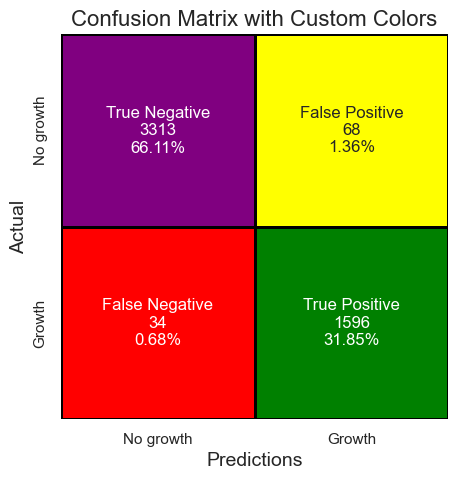

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, Normalize

# Define the custom colormap
cmap = ListedColormap(['purple', 'yellow', 'red', 'green'])
norm = Normalize(vmin=0, vmax=3)

# Confusion matrix values
confusion_matrix = np.array([
    [3313, 68],   # TN, FP
    [34, 1596]    # FN, TP
])


# Annotations
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)


# Map each outcome to a specific color
data_mapped = np.array([
    [0, 1],  # TN, FP
    [2, 3]   # FN, TP
])

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(data_mapped, annot=labels, fmt='', cmap=cmap, norm=norm, ax=ax, cbar=False,linewidth=0.9,linecolor='black')


# Setting axis labels
ax.set_xlabel('Predictions', fontsize=14)
ax.set_ylabel('Actual', fontsize=14)
ax.set_xticklabels(['No growth', 'Growth'])
ax.set_yticklabels(['No growth', 'Growth'])
plt.title('Confusion Matrix with Custom Colors', fontsize=16)
#plt.savefig('/Users/omidard/Desktop/confusion_marix.png', dpi=300, bbox_inches='tight')
plt.show()


### Formulation and analysis of panGPRs

---

we first formulate a presence absence matrix of reactions across panGEM, then each cell of the matrix is filled with genes identifiers (locustags) of the corresponding reaction/strain.

we then load the pangenome of E.coli (see )
we mapp locustags to their corresponding gene cluster identifier.
we analyse the genetic make-ups of formulated panGPRs

#### 1-Reaction presence/absence call across panGEM

In [28]:
# define path to GEMs and E.coli pangenome in eco_gems_allels.py
#file_path = "/path/to/header_to_allele.pickle"
#model_folder = '/path/to/GEMs'

# run the following command in terminal
# eco_gems_allels.py


# load the GPRs presence/absence


import pandas as pd
file_path = "/Users/omidard/Desktop/EcolipanGEM_final_panels/raw/ecoli_gprs_test_curated.csv"
# Read the file into a DataFrame
ecoli_gprs_test_curated = pd.read_csv(file_path)
ecoli_gprs_test_curated.fillna('Not found',inplace=True)
ecoli_gprs_test_curated

Unnamed: 0  \
0           1033813.3.json.json   
1          1038927.31.json.json   
2          1038927.40.json.json   
3          1038927.41.json.json   
4          1038927.45.json.json   
...                         ...   
2372  GCF_905332355.1.json.json   
2373  GCF_905332365.1.json.json   
2374  GCF_910591805.1.json.json   
2375  GCF_916098155.1.json.json   
2376  GCF_916098175.1.json.json   

                                              12PPDRtex  \
0     ['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756...   
1     ['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348...   
2     ['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...   
3                  ['b0929', 'b0241', 'b2215', 'b1377']   
4     ['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...   
...                                                 ...   
2372  ['Ecoli_C23968', 'Ecoli_C34348', 'Ecoli_C33756...   
2373  ['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...   
2374  ['Ecoli_C33756', 'Ecoli_C34348', 'Ecoli_C29968...   
2375  ['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...   
2376  ['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C33756...   

                                              12PPDStex           13PPDH2  \
0     ['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756...  ['Ecoli_C27728']   
1     ['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348...  ['Ecoli_C27728']   
2     ['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...  ['Ecoli_C27728']   
3                  ['b0929', 'b0241', 'b2215', 'b1377']         ['b3011']   
4     ['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...  ['Ecoli_C27728']   
...                                                 ...               ...   
2372  ['Ecoli_C23968', 'Ecoli_C34348', 'Ecoli_C33756...  ['Ecoli_C27728']   
2373  ['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...  ['Ecoli_C27728']   
2374  ['Ecoli_C33756', 'Ecoli_C34348', 'Ecoli_C29968...  ['Ecoli_C27728']   
2375  ['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...  ['Ecoli_C27728']   
2376  ['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C33756...  ['Ecoli_C27728']   

                                          14GLUCANabcpp      14GLUCANtexi  \
0     ['Ecoli_C51289', 'Ecoli_C30587', 'Ecoli_C16819...  ['Ecoli_C22772']   
1     ['Ecoli_C51289', 'Ecoli_C16819', 'Ecoli_C27486...  ['Ecoli_C22772']   
2     ['Ecoli_C30587', 'Ecoli_C16819', 'Ecoli_C51289...  ['Ecoli_C22772']   
3                  ['b4034', 'b4035', 'b4032', 'b4033']         ['b4036']   
4     ['Ecoli_C16819', 'Ecoli_C51289', 'Ecoli_C27486...  ['Ecoli_C22772']   
...                                                 ...               ...   
2372  ['Ecoli_C30587', 'Ecoli_C16819', 'Ecoli_C27486...  ['Ecoli_C22772']   
2373  ['Ecoli_C27486', 'Ecoli_C16819', 'Ecoli_C30587...  ['Ecoli_C22772']   
2374  ['Ecoli_C30587', 'Ecoli_C16819', 'Ecoli_C51289...  ['Ecoli_C22772']   
2375  ['Ecoli_C27486', 'Ecoli_C16819', 'Ecoli_C30587...  ['Ecoli_C22772']   
2376  ['Ecoli_C27486', 'Ecoli_C16819', 'Ecoli_C30587...  ['Ecoli_C22772']   

                                              23CAMPtex  \
0     ['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756...   
1     ['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348...   
2     ['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...   
3                  ['b0929', 'b0241', 'b2215', 'b1377']   
4     ['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...   
...                                                 ...   
2372  ['Ecoli_C23968', 'Ecoli_C34348', 'Ecoli_C33756...   
2373  ['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...   
2374  ['Ecoli_C33756', 'Ecoli_C34348', 'Ecoli_C29968...   
2375  ['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...   
2376  ['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C33756...   

                                              23CCMPtex  \
0     ['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756...   
1     ['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348...   
2     ['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...   
3                  ['b0929', 'b0241', 'b2215', 'b1377']   
4     ['Ecoli_C34348', 'Ecoli_C33756'

In [25]:
# Load the pangenome of E.coli
import pandas as pd
file_path = '/Users/omidard/Desktop/figs2/ess_mapped_genes_with_category.csv'
pangenome_df = pd.read_csv(file_path)
pangenome_df.drop(columns=['Essential'],inplace=True)
pangenome_df.columns = ['locus_tag','Gene','Category']
pangenome_df

locus_tag          Gene   Category
0         EPJPPNAH_02825   Ecoli_C6620       Core
1         EPJPPNAH_00232  Ecoli_C34348       Rare
2         EPJPPNAH_00920  Ecoli_C29968  Accessory
3         EPJPPNAH_01370  Ecoli_C23968       Rare
4         EPJPPNAH_02206  Ecoli_C33756       Core
...                  ...           ...        ...
10809018  BELAINIL_03275  Ecoli_C40265       Core
10809019  BELAINIL_01264  Ecoli_C34348       Rare
10809020  BELAINIL_02060  Ecoli_C29968  Accessory
10809021  BELAINIL_02729  Ecoli_C23968       Rare
10809022  BELAINIL_03625  Ecoli_C33756       Core

[10809023 rows x 3 columns]

In [29]:
reactions = []
genes_list = []
for i in ecoli_gprs_test_curated.columns:
    g =[]
    r =[]
    for x in ecoli_gprs_test_curated.index:
        reaction = i
        genes = []
        for v in range(len(ecoli_gprs_test_curated[i][x].split("', '"))):
            gene = ecoli_gprs_test_curated[i][x].split("', '")[v].replace("']","").replace("['","")
            genes.append(gene)
        g.append(genes)
    genes_list.append(g)
    if i !='Unnamed: 0':
        reactions.append(i)

In [30]:
genes_list_curated = []
for i in range(len(genes_list)):
    if i>0:
        genes = []
        for v in range(len(genes_list[i])):
            for g in genes_list[i][v]:
                if 'Ecoli_' in g:
                    if g not in genes:
                        genes.append(g)
        genes_list_curated.append(genes)

In [31]:
import pandas as pd
file_path = '/Users/omidard/data/datas/phylon_locustags_df.csv'

# Use pandas to read the compressed pickle file
merged_df = pd.read_csv(file_path)
#df_core_accessory = df[df['Category'] != 'Rare']
#df_Rare_TEs = df[df['Category'] == 'Rare']
merged_df

Model   Reaction                                 Genes  \
0         624.1185     CYTDK2                    ['HECBCEFB_00100']   
1         624.1185       XPPT                    ['HECBCEFB_03043']   
2         624.1185      HXPRT  ['HECBCEFB_02880', 'HECBCEFB_03043']   
3         624.1185      NDPK5  ['HECBCEFB_00626', 'HECBCEFB_03228']   
4         624.1185     SHK3Dr  ['HECBCEFB_04323', 'HECBCEFB_01505']   
...            ...        ...                                   ...   
5322711  562.28307     FESD1s                             ['s0001']   
5322712  562.28307     DHGLYH                             ['s0001']   
5322713  562.28307  NOVBCNtex                             ['s0001']   
5322714  562.28307   DHPTDCs2                             ['s0001']   
5322715  562.28307     FESD2s                             ['s0001']   

          primary_phylon  
0        Shigella-sonnei  
1        Shigella-sonnei  
2        Shigella-sonnei  
3        Shigella-sonnei  
4        Shigella-sonnei  
...                  ...  
5322711            A-hot  
5322712            A-hot  
5322713            A-hot  
5322714            A-hot  
5322715            A-hot  

[5322716 rows x 4 columns]

In [32]:
import pandas as pd
file_path = "/Users/omidard/data/files/curated_metadata_mash_filtered.pickle"

# Load the pickle file into a dataframe
meta = pd.read_pickle(file_path)
meta.set_index(['genome_id'],inplace=True)
meta.fillna('no',inplace=True)
meta

/var/folders/g4/gzd2bm953vs0rn_qkz4wyd1w0000gp/T/ipykernel_25977/1006930445.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'no' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  meta.fillna('no',inplace=True)


genome_name            organism_name  \
genome_id                                                                   
1446751.3  Escherichia coli O69:H11 str. 07-3763                       no   
562.22040    Escherichia coli strain MOD1-EC6044                       no   
1181766.3                Escherichia coli KTE220  Escherichia coli KTE220   
562.16440        Escherichia coli strain OLC1062                       no   
536056.3                    Escherichia coli DH1     Escherichia coli DH1   
...                                          ...                      ...   
625.135             Shigella sp. strain UBA12579                       no   
625.112              Shigella sp. strain UBA8062                       no   
625.113             Shigella sp. strain UBA12342                       no   
625.138             Shigella sp. strain UBA11973                       no   
625.65              Shigella sp. strain UBA10895                       no   

            taxon_id genome_status              strain  serovar pathovar  \
genome_id                                                                  
1446751.3  1446751.0           WGS             07-3763       no       no   
562.22040      562.0           WGS  strain MOD1-EC6044   O6:H31       no   
1181766.3  1181766.0           WGS              KTE220       no       no   
562.16440      562.0           WGS      strain OLC1062  O103:H2       no   
536056.3    536056.0      Complete                 DH1       no       no   
...              ...           ...                 ...      ...      ...   
625.135        625.0           WGS     strain UBA12579       no       no   
625.112        625.0           WGS      strain UBA8062       no       no   
625.113        625.0           WGS     strain UBA12342       no       no   
625.138        625.0           WGS     strain UBA11973       no       no   
625.65         625.0           WGS     strain UBA10895       no       no   

          culture_collection       completion_date publication  ...  \
genome_id                                                       ...   
1446751.3                 no  2014-06-11T00:00:00Z          no  ...   
562.22040                 no  2017-10-13T00:00:00Z          no  ...   
1181766.3                 no  2012-12-19T00:00:00Z          no  ...   
562.16440                 no  2017-05-12T00:00:00Z          no  ...   
536056.3                  no  2009-10-05T00:00:00Z          no  ...   
...                      ...                   ...         ...  ...   
625.135                   no  2018-09-10T00:00:00Z    30148503  ...   
625.112                   no  2018-09-10T00:00:00Z    30148503  ...   
625.113                   no  2018-09-10T00:00:00Z    30148503  ...   
625.138                   no  2018-09-06T00:00:00Z    30148503  ...   
625.65                    no  1900-01-01T00:00:00Z    30148503  ...   

          oxygen_requirement disease  \
genome_id                              
1446751.3                 no      no   
562.22040                 no      no   
1181766.3                 no      no   
562.16440                 no      no   
536056.3         Facultative      no   
...                      ...     ...   
625.135                   no      no   
625.112                   no      no   
625.113                   no      no   
625.138                   no      no   
625.65                    no      no   

                                                    comments  \
genome_id                                                      
1446751.3             PulseNet STEC genome reference library   
562.22040  Whole genome sequencing of cultured E. coli as...   
1181766.3         Genome Sequencing of E. coli UTI Defensins   
562.16440  The comprehensive analysis of priority food pa...   
536056.3   Escherichia coli DH1. Escherichia coli DH1 is ...   
...                                                      ...   
625.135    Collection of 3,087 bacterial metagenome-assem...   
625.112    Collection of 

In [33]:
import pandas as pd

# Assuming merged_df and meta are already defined and loaded

# Ensure 'Model' is a column in merged_df and index in meta
# If 'Model' is not the index in meta, you can set it as:
# meta.set_index('Model', inplace=True)
# Perform the merge operation
merged_df_with_phylogroup = merged_df.merge(meta[['phylogroup']], left_on='Model', right_index=True, how='left')
# Now merged_df_with_phylogroup will contain the 'phylogroup' column
merged_df_with_phylogroup


Model   Reaction                                 Genes  \
0         624.1185     CYTDK2                    ['HECBCEFB_00100']   
1         624.1185       XPPT                    ['HECBCEFB_03043']   
2         624.1185      HXPRT  ['HECBCEFB_02880', 'HECBCEFB_03043']   
3         624.1185      NDPK5  ['HECBCEFB_00626', 'HECBCEFB_03228']   
4         624.1185     SHK3Dr  ['HECBCEFB_04323', 'HECBCEFB_01505']   
...            ...        ...                                   ...   
5322711  562.28307     FESD1s                             ['s0001']   
5322712  562.28307     DHGLYH                             ['s0001']   
5322713  562.28307  NOVBCNtex                             ['s0001']   
5322714  562.28307   DHPTDCs2                             ['s0001']   
5322715  562.28307     FESD2s                             ['s0001']   

          primary_phylon phylogroup  
0        Shigella-sonnei    Unknown  
1        Shigella-sonnei    Unknown  
2        Shigella-sonnei    Unknown  
3        Shigella-sonnei    Unknown  
4        Shigella-sonnei    Unknown  
...                  ...        ...  
5322711            A-hot          A  
5322712            A-hot          A  
5322713            A-hot          A  
5322714            A-hot          A  
5322715            A-hot          A  

[5322716 rows x 5 columns]

In [34]:
# Group by 'phylogroup' and count unique 'Reaction' values for each group
reaction_counts_per_phylogroup = merged_df_with_phylogroup.groupby('phylogroup')['Reaction'].nunique().reset_index()

# Rename the columns for clarity
reaction_counts_per_phylogroup.columns = ['phylogroup', 'unique_reaction_count']

# Print out the results
for index, row in reaction_counts_per_phylogroup.iterrows():
    print(f"Phylogroup: {row['phylogroup']}, Distinct Reaction Count: {row['unique_reaction_count']}")


Phylogroup: A, Distinct Reaction Count: 2477
Phylogroup: B1, Distinct Reaction Count: 2476
Phylogroup: B2, Distinct Reaction Count: 2474
Phylogroup: C, Distinct Reaction Count: 2456
Phylogroup: D, Distinct Reaction Count: 2476
Phylogroup: E, Distinct Reaction Count: 2476
Phylogroup: E or cladeI, Distinct Reaction Count: 2226
Phylogroup: F, Distinct Reaction Count: 2475
Phylogroup: G, Distinct Reaction Count: 2473
Phylogroup: Unknown, Distinct Reaction Count: 2448
Phylogroup: cladeI, Distinct Reaction Count: 2268


In [35]:
ecoli_gprs_test_curated['index'] = [v.replace('.json.json','') for v in ecoli_gprs_test['Unnamed: 0']]
ecoli_gprs_test_curated.drop(columns=['Unnamed: 0'],inplace=True)
ecoli_gprs_test_curated.set_index('index',inplace=True)
ecoli_gprs_test_curated

12PPDRtex  \
index                                                                
1033813.3        ['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756...   
1038927.31       ['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348...   
1038927.40       ['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...   
1038927.41                    ['b0929', 'b0241', 'b2215', 'b1377']   
1038927.45       ['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...   
...                                                            ...   
GCF_905332355.1  ['Ecoli_C23968', 'Ecoli_C34348', 'Ecoli_C33756...   
GCF_905332365.1  ['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...   
GCF_910591805.1  ['Ecoli_C33756', 'Ecoli_C34348', 'Ecoli_C29968...   
GCF_916098155.1  ['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...   
GCF_916098175.1  ['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C33756...   

                                                         12PPDStex  \
index                                                                
1033813.3        ['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756...   
1038927.31       ['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348...   
1038927.40       ['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...   
1038927.41                    ['b0929', 'b0241', 'b2215', 'b1377']   
1038927.45       ['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...   
...                                                            ...   
GCF_905332355.1  ['Ecoli_C23968', 'Ecoli_C34348', 'Ecoli_C33756...   
GCF_905332365.1  ['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...   
GCF_910591805.1  ['Ecoli_C33756', 'Ecoli_C34348', 'Ecoli_C29968...   
GCF_916098155.1  ['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...   
GCF_916098175.1  ['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C33756...   

                          13PPDH2  \
index                               
1033813.3        ['Ecoli_C27728']   
1038927.31       ['Ecoli_C27728']   
1038927.40       ['Ecoli_C27728']   
1038927.41              ['b3011']   
1038927.45       ['Ecoli_C27728']   
...                           ...   
GCF_905332355.1  ['Ecoli_C27728']   
GCF_905332365.1  ['Ecoli_C27728']   
GCF_910591805.1  ['Ecoli_C27728']   
GCF_916098155.1  ['Ecoli_C27728']   
GCF_916098175.1  ['Ecoli_C27728']   

                                                     14GLUCANabcpp  \
index                                                                
1033813.3        ['Ecoli_C51289', 'Ecoli_C30587', 'Ecoli_C16819...   
1038927.31       ['Ecoli_C51289', 'Ecoli_C16819', 'Ecoli_C27486...   
1038927.40       ['Ecoli_C30587', 'Ecoli_C16819', 'Ecoli_C51289...   
1038927.41                    ['b4034', 'b4035', 'b4032', 'b4033']   
1038927.45       ['Ecoli_C16819', 'Ecoli_C51289', 'Ecoli_C27486...   
...                                                            ...   
GCF_905332355.1  ['Ecoli_C30587', 'Ecoli_C16819', 'Ecoli_C27486...   
GCF_905332365.1  ['Ecoli_C27486', 'Ecoli_C16819', 'Ecoli_C30587...   
GCF_910591805.1  ['Ecoli_C30587', 'Ecoli_C16819', 'Ecoli_C51289...   
GCF_916098155.1  ['Ecoli_C27486', 'Ecoli_C16819', 'Ecoli_C30587...   
GCF_916098175.1  ['Ecoli_C27486', 'Ecoli_C16819', 'Ecoli_C30587...   

                     14GLUCANtexi  \
index                               
1033813.3        ['Ecoli_C22772']   
1038927.31       ['Ecoli_C22772']   
1038927.40       ['Ecoli_C22772']   
1038927.41              ['b4036']   
1038927.45       ['Ecoli_C22772']   
...                           ...   
GCF_905332355.1  ['Ecoli_C22772']   
GCF_905332365.1  ['Ecoli_C22772']   
GCF_910591805.1  ['Ecoli_C22772']   
GCF_916098155.1  ['Ecoli_C22772']   
GCF_916098175.1  ['Ecoli_C22772']   

                                                         23CAMPtex  \
index                                                                
1033813.3        ['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756...   
1038927.31       ['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348...   
1038927.40       ['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...   
1038927.41

In [39]:
# Using pivot to transform back to expanded form
expanded_df = merged_df.pivot(index='Model', columns='Reaction', values='Genes').reset_index()

In [40]:
expanded_df = merged_df.pivot(index='Model', columns='Reaction', values='primary_phylon').reset_index()
expanded_df.set_index('Model',inplace=True)

In [41]:
ecoli_gprs_test_curated['primary_phylon'] = 'ND'
for i in ecoli_gprs_test_curated.index:
    ecoli_gprs_test_curated['primary_phylon'][i] = expanded_df['12PPDRtex'][i]

/var/folders/g4/gzd2bm953vs0rn_qkz4wyd1w0000gp/T/ipykernel_25977/3276232414.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ecoli_gprs_test_curated['primary_phylon'][i] = expanded_df['12PPDRtex'][i]
/var/folders/g4/gzd2bm953vs0rn_qkz4wyd

In [43]:
import pandas as pd

# Assuming ecoli_gprs_test is your DataFrame

# Define a function to check for the presence of 'Ecoli_' in a row
def contains_ecoli(row):
    return any('Ecoli_' in str(cell) for cell in row)

# Apply the function to filter the DataFrame
filtered_df = ecoli_gprs_test_curated[ecoli_gprs_test_curated.apply(contains_ecoli, axis=1)]


In [44]:
import pandas as pd
import ast

# Assuming filtered_df is your dataframe
def convert_to_list(cell_value):
    try:
        return ast.literal_eval(cell_value)
    except (ValueError, SyntaxError):
        return []

for column in filtered_df.columns:
    if column != "primary_phylon":
        filtered_df[column] = filtered_df[column].apply(convert_to_list)

/var/folders/g4/gzd2bm953vs0rn_qkz4wyd1w0000gp/T/ipykernel_25977/3131030775.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(convert_to_list)


In [45]:
phylon_genes = filtered_df.groupby("primary_phylon").agg(lambda x: [gene for sublist in x for gene in sublist])

In [46]:
BL21_minus = list(set(phylon_genes.index) - set(['A-BL21']))
phylon_genes_BL21_minus = phylon_genes.copy()
for i in phylon_genes_BL21_minus.index:
    if i not in BL21_minus:
        phylon_genes_BL21_minus.drop(i,inplace=True)


phylon_genes_BL21 = phylon_genes.copy()
for i in phylon_genes_BL21.index:
    if i in BL21_minus:
        phylon_genes_BL21.drop(i,inplace=True)

In [47]:
# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_BL21_minus_data = phylon_genes_BL21_minus.values.tolist()
phylon_genes_BL21_data = phylon_genes_BL21.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_BL21_minus_genes = set()
phylon_genes_BL21_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_BL21_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_BL21_minus_genes.add(gene)

for row in phylon_genes_BL21_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_BL21_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_BL21_minus_genes = list(phylon_genes_BL21_minus_genes)
phylon_genes_BL21_genes = list(phylon_genes_BL21_genes)

exclusive_BL21 = set(phylon_genes_BL21_genes) - set(phylon_genes_BL21_minus_genes)

print('exclusive_BL21 =',len(exclusive_BL21))

exclusive_BL21 = 30


In [48]:
Shigella_sonnei_minus = list(set(phylon_genes.index) - set(['Shigella-sonnei']))
phylon_genes_Shigella_sonnei_minus = phylon_genes.copy()
for i in phylon_genes_Shigella_sonnei_minus.index:
    if i not in Shigella_sonnei_minus:
        phylon_genes_Shigella_sonnei_minus.drop(i,inplace=True)


phylon_genes_Shigella_sonnei = phylon_genes.copy()
for i in phylon_genes_Shigella_sonnei.index:
    if i in Shigella_sonnei_minus:
        phylon_genes_Shigella_sonnei.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_Shigella_sonnei_minus_data = phylon_genes_Shigella_sonnei_minus.values.tolist()
phylon_genes_Shigella_sonnei_data = phylon_genes_Shigella_sonnei.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_Shigella_sonnei_minus_genes = set()
phylon_genes_Shigella_sonnei_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_Shigella_sonnei_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_Shigella_sonnei_minus_genes.add(gene)

for row in phylon_genes_Shigella_sonnei_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_Shigella_sonnei_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_Shigella_sonnei_minus_genes = list(phylon_genes_Shigella_sonnei_minus_genes)
phylon_genes_Shigella_sonnei_genes = list(phylon_genes_Shigella_sonnei_genes)

exclusive_Shigella_sonnei = set(phylon_genes_Shigella_sonnei_genes) - set(phylon_genes_Shigella_sonnei_minus_genes)

print('exclusive_Shigella_sonnei =',len(exclusive_Shigella_sonnei))

exclusive_Shigella_sonnei = 55


In [49]:
A_K12_minus = list(set(phylon_genes.index) - set(['A-K12']))
phylon_genes_A_K12_minus = phylon_genes.copy()
for i in phylon_genes_A_K12_minus.index:
    if i not in A_K12_minus:
        phylon_genes_A_K12_minus.drop(i,inplace=True)


phylon_genes_A_K12 = phylon_genes.copy()
for i in phylon_genes_A_K12.index:
    if i in A_K12_minus:
        phylon_genes_A_K12.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_A_K12_minus_data = phylon_genes_A_K12_minus.values.tolist()
phylon_genes_A_K12_data = phylon_genes_A_K12.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_A_K12_minus_genes = set()
phylon_genes_A_K12_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_A_K12_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_A_K12_minus_genes.add(gene)

for row in phylon_genes_A_K12_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_A_K12_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_A_K12_minus_genes = list(phylon_genes_A_K12_minus_genes)
phylon_genes_A_K12_genes = list(phylon_genes_A_K12_genes)

exclusive_A_K12 = set(phylon_genes_A_K12_genes) - set(phylon_genes_A_K12_minus_genes)

print('exclusive_A_K12 =',len(exclusive_A_K12))

exclusive_A_K12 = 91


In [50]:
A_Sanji_minus = list(set(phylon_genes.index) - set(['A-Sanji']))
phylon_genes_A_Sanji_minus = phylon_genes.copy()
for i in phylon_genes_A_Sanji_minus.index:
    if i not in A_Sanji_minus:
        phylon_genes_A_Sanji_minus.drop(i,inplace=True)


phylon_genes_A_Sanji = phylon_genes.copy()
for i in phylon_genes_A_Sanji.index:
    if i in A_Sanji_minus:
        phylon_genes_A_Sanji.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_A_Sanji_minus_data = phylon_genes_A_Sanji_minus.values.tolist()
phylon_genes_A_Sanji_data = phylon_genes_A_Sanji.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_A_Sanji_minus_genes = set()
phylon_genes_A_Sanji_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_A_Sanji_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_A_Sanji_minus_genes.add(gene)

for row in phylon_genes_A_Sanji_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_A_Sanji_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_A_Sanji_minus_genes = list(phylon_genes_A_Sanji_minus_genes)
phylon_genes_A_Sanji_genes = list(phylon_genes_A_Sanji_genes)

exclusive_A_Sanji = set(phylon_genes_A_Sanji_genes) - set(phylon_genes_A_Sanji_minus_genes)

print('exclusive_A_Sanji =',len(exclusive_A_Sanji))

exclusive_A_Sanji = 38


In [51]:
A_Thailand_minus = list(set(phylon_genes.index) - set(['A-Thailand']))
phylon_genes_A_Thailand_minus = phylon_genes.copy()
for i in phylon_genes_A_Thailand_minus.index:
    if i not in A_Thailand_minus:
        phylon_genes_A_Thailand_minus.drop(i,inplace=True)


phylon_genes_A_Thailand = phylon_genes.copy()
for i in phylon_genes_A_Thailand.index:
    if i in A_Thailand_minus:
        phylon_genes_A_Thailand.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_A_Thailand_minus_data = phylon_genes_A_Thailand_minus.values.tolist()
phylon_genes_A_Thailand_data = phylon_genes_A_Thailand.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_A_Thailand_minus_genes = set()
phylon_genes_A_Thailand_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_A_Thailand_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_A_Thailand_minus_genes.add(gene)

for row in phylon_genes_A_Thailand_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_A_Thailand_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_A_Thailand_minus_genes = list(phylon_genes_A_Thailand_minus_genes)
phylon_genes_A_Thailand_genes = list(phylon_genes_A_Thailand_genes)

exclusive_A_Thailand = set(phylon_genes_A_Thailand_genes) - set(phylon_genes_A_Thailand_minus_genes)

print('exclusive_A_Thailand =',len(exclusive_A_Thailand))

exclusive_A_Thailand = 31


In [52]:
A_hot_minus = list(set(phylon_genes.index) - set(['A-hot']))
phylon_genes_A_hot_minus = phylon_genes.copy()
for i in phylon_genes_A_hot_minus.index:
    if i not in A_hot_minus:
        phylon_genes_A_hot_minus.drop(i,inplace=True)


phylon_genes_A_hot = phylon_genes.copy()
for i in phylon_genes_A_hot.index:
    if i in A_hot_minus:
        phylon_genes_A_hot.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_A_hot_minus_data = phylon_genes_A_hot_minus.values.tolist()
phylon_genes_A_hot_data = phylon_genes_A_hot.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_A_hot_minus_genes = set()
phylon_genes_A_hot_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_A_hot_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                if gene not in phylon_genes_A_hot_minus_genes:
                    phylon_genes_A_hot_minus_genes.add(gene)

for row in phylon_genes_A_hot_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                if gene not in phylon_genes_A_hot_genes:
                    phylon_genes_A_hot_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_A_hot_minus_genes = list(phylon_genes_A_hot_minus_genes)
phylon_genes_A_hot_genes = list(phylon_genes_A_hot_genes)

exclusive_A_hot = set(phylon_genes_A_hot_genes) - set(phylon_genes_A_hot_minus_genes)

print('exclusive_A_hot =',len(exclusive_A_hot))

exclusive_A_hot = 15


In [53]:
A_other_minus = list(set(phylon_genes.index) - set(['A-other']))
phylon_genes_A_other_minus = phylon_genes.copy()
for i in phylon_genes_A_other_minus.index:
    if i not in A_other_minus:
        phylon_genes_A_other_minus.drop(i,inplace=True)


phylon_genes_A_other = phylon_genes.copy()
for i in phylon_genes_A_other.index:
    if i in A_other_minus:
        phylon_genes_A_other.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_A_other_minus_data = phylon_genes_A_other_minus.values.tolist()
phylon_genes_A_other_data = phylon_genes_A_other.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_A_other_minus_genes = set()
phylon_genes_A_other_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_A_other_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                if gene not in phylon_genes_A_other_minus_genes:
                    phylon_genes_A_other_minus_genes.add(gene)

for row in phylon_genes_A_other_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                if gene not in phylon_genes_A_other_genes:
                    phylon_genes_A_other_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_A_other_minus_genes = list(phylon_genes_A_other_minus_genes)
phylon_genes_A_other_genes = list(phylon_genes_A_other_genes)

exclusive_A_other = set(phylon_genes_A_other_genes) - set(phylon_genes_A_other_minus_genes)

print('exclusive_A_other =',len(exclusive_A_other))

exclusive_A_other = 457


In [54]:
B1_ST678_minus = list(set(phylon_genes.index) - set(['B1-ST678']))
phylon_genes_B1_ST678_minus = phylon_genes.copy()
for i in phylon_genes_B1_ST678_minus.index:
    if i not in B1_ST678_minus:
        phylon_genes_B1_ST678_minus.drop(i,inplace=True)


phylon_genes_B1_ST678 = phylon_genes.copy()
for i in phylon_genes_B1_ST678.index:
    if i in B1_ST678_minus:
        phylon_genes_B1_ST678.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_B1_ST678_minus_data = phylon_genes_B1_ST678_minus.values.tolist()
phylon_genes_B1_ST678_data = phylon_genes_B1_ST678.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_B1_ST678_minus_genes = set()
phylon_genes_B1_ST678_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_B1_ST678_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_B1_ST678_minus_genes.add(gene)

for row in phylon_genes_B1_ST678_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_B1_ST678_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_B1_ST678_minus_genes = list(phylon_genes_B1_ST678_minus_genes)
phylon_genes_B1_ST678_genes = list(phylon_genes_B1_ST678_genes)

exclusive_B1_ST678 = set(phylon_genes_B1_ST678_genes) - set(phylon_genes_B1_ST678_minus_genes)

print('exclusive_B1_ST678 =',len(exclusive_B1_ST678))

exclusive_B1_ST678 = 3


In [55]:
B1_ShigaToxin_minus = list(set(phylon_genes.index) - set(['B1-ShigaToxin']))
phylon_genes_B1_ShigaToxin_minus = phylon_genes.copy()
for i in phylon_genes_B1_ShigaToxin_minus.index:
    if i not in B1_ShigaToxin_minus:
        phylon_genes_B1_ShigaToxin_minus.drop(i,inplace=True)


phylon_genes_B1_ShigaToxin = phylon_genes.copy()
for i in phylon_genes_B1_ShigaToxin.index:
    if i in B1_ShigaToxin_minus:
        phylon_genes_B1_ShigaToxin.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_B1_ShigaToxin_minus_data = phylon_genes_B1_ShigaToxin_minus.values.tolist()
phylon_genes_B1_ShigaToxin_data = phylon_genes_B1_ShigaToxin.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_B1_ShigaToxin_minus_genes = set()
phylon_genes_B1_ShigaToxin_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_B1_ShigaToxin_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_B1_ShigaToxin_minus_genes.add(gene)

for row in phylon_genes_B1_ShigaToxin_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_B1_ShigaToxin_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_B1_ShigaToxin_minus_genes = list(phylon_genes_B1_ShigaToxin_minus_genes)
phylon_genes_B1_ShigaToxin_genes = list(phylon_genes_B1_ShigaToxin_genes)

exclusive_B1_ShigaToxin = set(phylon_genes_B1_ShigaToxin_genes) - set(phylon_genes_B1_ShigaToxin_minus_genes)

print('exclusive_B1_ShigaToxin =',len(exclusive_B1_ShigaToxin))

exclusive_B1_ShigaToxin = 97


In [56]:
B1_other_minus = list(set(phylon_genes.index) - set(['B1-other']))
phylon_genes_B1_other_minus = phylon_genes.copy()
for i in phylon_genes_B1_other_minus.index:
    if i not in B1_other_minus:
        phylon_genes_B1_other_minus.drop(i,inplace=True)


phylon_genes_B1_other = phylon_genes.copy()
for i in phylon_genes_B1_other.index:
    if i in B1_other_minus:
        phylon_genes_B1_other.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_B1_other_minus_data = phylon_genes_B1_other_minus.values.tolist()
phylon_genes_B1_other_data = phylon_genes_B1_other.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_B1_other_minus_genes = set()
phylon_genes_B1_other_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_B1_other_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_B1_other_minus_genes.add(gene)

for row in phylon_genes_B1_other_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_B1_other_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_B1_other_minus_genes = list(phylon_genes_B1_other_minus_genes)
phylon_genes_B1_other_genes = list(phylon_genes_B1_other_genes)

exclusive_B1_other = set(phylon_genes_B1_other_genes) - set(phylon_genes_B1_other_minus_genes)

print('exclusive_B1_other =',len(exclusive_B1_other))

exclusive_B1_other = 430


In [57]:
B2_ST131_minus = list(set(phylon_genes.index) - set(['B2-ST131']))
phylon_genes_B2_ST131_minus = phylon_genes.copy()
for i in phylon_genes_B2_ST131_minus.index:
    if i not in B2_ST131_minus:
        phylon_genes_B2_ST131_minus.drop(i,inplace=True)


phylon_genes_B2_ST131 = phylon_genes.copy()
for i in phylon_genes_B2_ST131.index:
    if i in B2_ST131_minus:
        phylon_genes_B2_ST131.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_B2_ST131_minus_data = phylon_genes_B2_ST131_minus.values.tolist()
phylon_genes_B2_ST131_data = phylon_genes_B2_ST131.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_B2_ST131_minus_genes = set()
phylon_genes_B2_ST131_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_B2_ST131_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_B2_ST131_minus_genes.add(gene)

for row in phylon_genes_B2_ST131_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_B2_ST131_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_B2_ST131_minus_genes = list(phylon_genes_B2_ST131_minus_genes)
phylon_genes_B2_ST131_genes = list(phylon_genes_B2_ST131_genes)

exclusive_B2_ST131 = set(phylon_genes_B2_ST131_genes) - set(phylon_genes_B2_ST131_minus_genes)

print('exclusive_B2_ST131 =',len(exclusive_B2_ST131))

exclusive_B2_ST131 = 159


In [58]:
B2_other_minus = list(set(phylon_genes.index) - set(['B2-other']))
phylon_genes_B2_other_minus = phylon_genes.copy()
for i in phylon_genes_B2_other_minus.index:
    if i not in B2_other_minus:
        phylon_genes_B2_other_minus.drop(i,inplace=True)


phylon_genes_B2_other = phylon_genes.copy()
for i in phylon_genes_B2_other.index:
    if i in B2_other_minus:
        phylon_genes_B2_other.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_B2_other_minus_data = phylon_genes_B2_other_minus.values.tolist()
phylon_genes_B2_other_data = phylon_genes_B2_other.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_B2_other_minus_genes = set()
phylon_genes_B2_other_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_B2_other_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_B2_other_minus_genes.add(gene)

for row in phylon_genes_B2_other_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_B2_other_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_B2_other_minus_genes = list(phylon_genes_B2_other_minus_genes)
phylon_genes_B2_other_genes = list(phylon_genes_B2_other_genes)

exclusive_B2_other = set(phylon_genes_B2_other_genes) - set(phylon_genes_B2_other_minus_genes)

print('exclusive_B2_other =',len(exclusive_B2_other))

exclusive_B2_other = 307


In [59]:
ind=[]
for i in phylon_genes.index:
    if i == 'C':
        i = 'phylon_C'
    ind.append(i)
phylon_genes.index = ind

phylon_C_minus = list(set(phylon_genes.index) - set(['phylon_C']))
phylon_genes_phylon_C_minus = phylon_genes.copy()
for i in phylon_genes_phylon_C_minus.index:
    if i not in phylon_C_minus:
        phylon_genes_phylon_C_minus.drop(i,inplace=True)


phylon_genes_phylon_C = phylon_genes.copy()
for i in phylon_genes_phylon_C.index:
    if i in phylon_C_minus:
        phylon_genes_phylon_C.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_phylon_C_minus_data = phylon_genes_phylon_C_minus.values.tolist()
phylon_genes_phylon_C_data = phylon_genes_phylon_C.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_phylon_C_minus_genes = set()
phylon_genes_phylon_C_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_phylon_C_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_phylon_C_minus_genes.add(gene)

for row in phylon_genes_phylon_C_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_phylon_C_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_phylon_C_minus_genes = list(phylon_genes_phylon_C_minus_genes)
phylon_genes_phylon_C_genes = list(phylon_genes_phylon_C_genes)

exclusive_phylon_C = set(phylon_genes_phylon_C_genes) - set(phylon_genes_phylon_C_minus_genes)

print('exclusive_phylon_C =',len(exclusive_phylon_C))

exclusive_phylon_C = 83


In [60]:
D_ST32_minus = list(set(phylon_genes.index) - set(['D-ST32']))
phylon_genes_D_ST32_minus = phylon_genes.copy()
for i in phylon_genes_D_ST32_minus.index:
    if i not in D_ST32_minus:
        phylon_genes_D_ST32_minus.drop(i,inplace=True)


phylon_genes_D_ST32 = phylon_genes.copy()
for i in phylon_genes_D_ST32.index:
    if i in D_ST32_minus:
        phylon_genes_D_ST32.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_D_ST32_minus_data = phylon_genes_D_ST32_minus.values.tolist()
phylon_genes_D_ST32_data = phylon_genes_D_ST32.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_D_ST32_minus_genes = set()
phylon_genes_D_ST32_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_D_ST32_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_D_ST32_minus_genes.add(gene)

for row in phylon_genes_D_ST32_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_D_ST32_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_D_ST32_minus_genes = list(phylon_genes_D_ST32_minus_genes)
phylon_genes_D_ST32_genes = list(phylon_genes_D_ST32_genes)

exclusive_D_ST32 = set(phylon_genes_D_ST32_genes) - set(phylon_genes_D_ST32_minus_genes)

print('exclusive_D_ST32 =',len(exclusive_D_ST32))

exclusive_D_ST32 = 11


In [61]:
D_ST38_minus = list(set(phylon_genes.index) - set(['D-ST38']))
phylon_genes_D_ST38_minus = phylon_genes.copy()
for i in phylon_genes_D_ST38_minus.index:
    if i not in D_ST38_minus:
        phylon_genes_D_ST38_minus.drop(i,inplace=True)


phylon_genes_D_ST38 = phylon_genes.copy()
for i in phylon_genes_D_ST38.index:
    if i in D_ST38_minus:
        phylon_genes_D_ST38.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_D_ST38_minus_data = phylon_genes_D_ST38_minus.values.tolist()
phylon_genes_D_ST38_data = phylon_genes_D_ST38.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_D_ST38_minus_genes = set()
phylon_genes_D_ST38_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_D_ST38_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_D_ST38_minus_genes.add(gene)

for row in phylon_genes_D_ST38_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_D_ST38_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_D_ST38_minus_genes = list(phylon_genes_D_ST38_minus_genes)
phylon_genes_D_ST38_genes = list(phylon_genes_D_ST38_genes)

exclusive_D_ST38 = set(phylon_genes_D_ST38_genes) - set(phylon_genes_D_ST38_minus_genes)

print('exclusive_D_ST38 =',len(exclusive_D_ST38))

exclusive_D_ST38 = 81


In [62]:
D_ST405_minus = list(set(phylon_genes.index) - set(['D-ST405']))
phylon_genes_D_ST405_minus = phylon_genes.copy()
for i in phylon_genes_D_ST405_minus.index:
    if i not in D_ST405_minus:
        phylon_genes_D_ST405_minus.drop(i,inplace=True)


phylon_genes_D_ST405 = phylon_genes.copy()
for i in phylon_genes_D_ST405.index:
    if i in D_ST405_minus:
        phylon_genes_D_ST405.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_D_ST405_minus_data = phylon_genes_D_ST405_minus.values.tolist()
phylon_genes_D_ST405_data = phylon_genes_D_ST405.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_D_ST405_minus_genes = set()
phylon_genes_D_ST405_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_D_ST405_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_D_ST405_minus_genes.add(gene)

for row in phylon_genes_D_ST405_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_D_ST405_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_D_ST405_minus_genes = list(phylon_genes_D_ST405_minus_genes)
phylon_genes_D_ST405_genes = list(phylon_genes_D_ST405_genes)

exclusive_D_ST405 = set(phylon_genes_D_ST405_genes) - set(phylon_genes_D_ST405_minus_genes)

print('exclusive_D_ST405 =',len(exclusive_D_ST405))

exclusive_D_ST405 = 14


In [63]:
D_ST69_minus = list(set(phylon_genes.index) - set(['D-ST69']))
phylon_genes_D_ST69_minus = phylon_genes.copy()
for i in phylon_genes_D_ST69_minus.index:
    if i not in D_ST69_minus:
        phylon_genes_D_ST69_minus.drop(i,inplace=True)


phylon_genes_D_ST69 = phylon_genes.copy()
for i in phylon_genes_D_ST69.index:
    if i in D_ST69_minus:
        phylon_genes_D_ST69.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_D_ST69_minus_data = phylon_genes_D_ST69_minus.values.tolist()
phylon_genes_D_ST69_data = phylon_genes_D_ST69.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_D_ST69_minus_genes = set()
phylon_genes_D_ST69_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_D_ST69_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_D_ST69_minus_genes.add(gene)

for row in phylon_genes_D_ST69_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_D_ST69_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_D_ST69_minus_genes = list(phylon_genes_D_ST69_minus_genes)
phylon_genes_D_ST69_genes = list(phylon_genes_D_ST69_genes)

exclusive_D_ST69 = set(phylon_genes_D_ST69_genes) - set(phylon_genes_D_ST69_minus_genes)

print('exclusive_D_ST69 =',len(exclusive_D_ST69))

exclusive_D_ST69 = 81


In [64]:
E_ST11_minus = list(set(phylon_genes.index) - set(['E-ST11']))
phylon_genes_E_ST11_minus = phylon_genes.copy()
for i in phylon_genes_E_ST11_minus.index:
    if i not in E_ST11_minus:
        phylon_genes_E_ST11_minus.drop(i,inplace=True)


phylon_genes_E_ST11 = phylon_genes.copy()
for i in phylon_genes_E_ST11.index:
    if i in E_ST11_minus:
        phylon_genes_E_ST11.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_E_ST11_minus_data = phylon_genes_E_ST11_minus.values.tolist()
phylon_genes_E_ST11_data = phylon_genes_E_ST11.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_E_ST11_minus_genes = set()
phylon_genes_E_ST11_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_E_ST11_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_E_ST11_minus_genes.add(gene)

for row in phylon_genes_E_ST11_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_E_ST11_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_E_ST11_minus_genes = list(phylon_genes_E_ST11_minus_genes)
phylon_genes_E_ST11_genes = list(phylon_genes_E_ST11_genes)

exclusive_E_ST11 = set(phylon_genes_E_ST11_genes) - set(phylon_genes_E_ST11_minus_genes)

print('exclusive_E_ST11 =',len(exclusive_E_ST11))

exclusive_E_ST11 = 97


In [65]:
ind=[]
for i in phylon_genes.index:
    if i == 'G':
        i = 'phylon_G'
    ind.append(i)
phylon_genes.index = ind

ind=[]
for i in phylon_genes.index:
    if i == 'F':
        i = 'phylon_F'
    ind.append(i)
phylon_genes.index = ind


phylon_F_minus = list(set(phylon_genes.index) - set(['phylon_F']))
phylon_genes_phylon_F_minus = phylon_genes.copy()
for i in phylon_genes_phylon_F_minus.index:
    if i not in phylon_F_minus:
        phylon_genes_phylon_F_minus.drop(i,inplace=True)


phylon_genes_phylon_F = phylon_genes.copy()
for i in phylon_genes_phylon_F.index:
    if i in phylon_F_minus:
        phylon_genes_phylon_F.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_phylon_F_minus_data = phylon_genes_phylon_F_minus.values.tolist()
phylon_genes_phylon_F_data = phylon_genes_phylon_F.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_phylon_F_minus_genes = set()
phylon_genes_phylon_F_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_phylon_F_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_phylon_F_minus_genes.add(gene)

for row in phylon_genes_phylon_F_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_phylon_F_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_phylon_F_minus_genes = list(phylon_genes_phylon_F_minus_genes)
phylon_genes_phylon_F_genes = list(phylon_genes_phylon_F_genes)

exclusive_phylon_F = set(phylon_genes_phylon_F_genes) - set(phylon_genes_phylon_F_minus_genes)

print('exclusive_phylon_F =',len(exclusive_phylon_F))


exclusive_phylon_F = 562


In [66]:
phylon_G_minus = list(set(phylon_genes.index) - set(['phylon_G']))
phylon_genes_phylon_G_minus = phylon_genes.copy()
for i in phylon_genes_phylon_G_minus.index:
    if i not in phylon_G_minus:
        phylon_genes_phylon_G_minus.drop(i,inplace=True)


phylon_genes_phylon_G = phylon_genes.copy()
for i in phylon_genes_phylon_G.index:
    if i in phylon_G_minus:
        phylon_genes_phylon_G.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_phylon_G_minus_data = phylon_genes_phylon_G_minus.values.tolist()
phylon_genes_phylon_G_data = phylon_genes_phylon_G.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_phylon_G_minus_genes = set()
phylon_genes_phylon_G_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_phylon_G_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_phylon_G_minus_genes.add(gene)

for row in phylon_genes_phylon_G_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_phylon_G_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_phylon_G_minus_genes = list(phylon_genes_phylon_G_minus_genes)
phylon_genes_phylon_G_genes = list(phylon_genes_phylon_G_genes)

exclusive_phylon_G = set(phylon_genes_phylon_G_genes) - set(phylon_genes_phylon_G_minus_genes)

print('exclusive_phylon_G =',len(exclusive_phylon_G))

exclusive_phylon_G = 69


In [67]:
Shigella_dysenteriae_boydii_minus = list(set(phylon_genes.index) - set(['Shigella-dysenteriae-boydii']))
phylon_genes_Shigella_dysenteriae_boydii_minus = phylon_genes.copy()
for i in phylon_genes_Shigella_dysenteriae_boydii_minus.index:
    if i not in Shigella_dysenteriae_boydii_minus:
        phylon_genes_Shigella_dysenteriae_boydii_minus.drop(i,inplace=True)


phylon_genes_Shigella_dysenteriae_boydii = phylon_genes.copy()
for i in phylon_genes_Shigella_dysenteriae_boydii.index:
    if i in Shigella_dysenteriae_boydii_minus:
        phylon_genes_Shigella_dysenteriae_boydii.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_Shigella_dysenteriae_boydii_minus_data = phylon_genes_Shigella_dysenteriae_boydii_minus.values.tolist()
phylon_genes_Shigella_dysenteriae_boydii_data = phylon_genes_Shigella_dysenteriae_boydii.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_Shigella_dysenteriae_boydii_minus_genes = set()
phylon_genes_Shigella_dysenteriae_boydii_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_Shigella_dysenteriae_boydii_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_Shigella_dysenteriae_boydii_minus_genes.add(gene)

for row in phylon_genes_Shigella_dysenteriae_boydii_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_Shigella_dysenteriae_boydii_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_Shigella_dysenteriae_boydii_minus_genes = list(phylon_genes_Shigella_dysenteriae_boydii_minus_genes)
phylon_genes_Shigella_dysenteriae_boydii_genes = list(phylon_genes_Shigella_dysenteriae_boydii_genes)

exclusive_Shigella_dysenteriae_boydii = set(phylon_genes_Shigella_dysenteriae_boydii_genes) - set(phylon_genes_Shigella_dysenteriae_boydii_minus_genes)

print('exclusive_Shigella_other =',len(exclusive_Shigella_dysenteriae_boydii))

exclusive_Shigella_other = 413


In [68]:
Shigella_flexneri_minus = list(set(phylon_genes.index) - set(['Shigella-flexneri']))
phylon_genes_Shigella_flexneri_minus = phylon_genes.copy()
for i in phylon_genes_Shigella_flexneri_minus.index:
    if i not in Shigella_flexneri_minus:
        phylon_genes_Shigella_flexneri_minus.drop(i,inplace=True)


phylon_genes_Shigella_flexneri = phylon_genes.copy()
for i in phylon_genes_Shigella_flexneri.index:
    if i in Shigella_flexneri_minus:
        phylon_genes_Shigella_flexneri.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_Shigella_flexneri_minus_data = phylon_genes_Shigella_flexneri_minus.values.tolist()
phylon_genes_Shigella_flexneri_data = phylon_genes_Shigella_flexneri.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_Shigella_flexneri_minus_genes = set()
phylon_genes_Shigella_flexneri_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_Shigella_flexneri_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_Shigella_flexneri_minus_genes.add(gene)

for row in phylon_genes_Shigella_flexneri_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_Shigella_flexneri_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_Shigella_flexneri_minus_genes = list(phylon_genes_Shigella_flexneri_minus_genes)
phylon_genes_Shigella_flexneri_genes = list(phylon_genes_Shigella_flexneri_genes)

exclusive_Shigella_flexneri = set(phylon_genes_Shigella_flexneri_genes) - set(phylon_genes_Shigella_flexneri_minus_genes)

print('exclusive_Shigella_flexneri =',len(exclusive_Shigella_flexneri))

exclusive_Shigella_flexneri = 202


In [69]:
unchar_1_minus = list(set(phylon_genes.index) - set(['unchar-1']))
phylon_genes_unchar_1_minus = phylon_genes.copy()
for i in phylon_genes_unchar_1_minus.index:
    if i not in unchar_1_minus:
        phylon_genes_unchar_1_minus.drop(i,inplace=True)


phylon_genes_unchar_1 = phylon_genes.copy()
for i in phylon_genes_unchar_1.index:
    if i in unchar_1_minus:
        phylon_genes_unchar_1.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_unchar_1_minus_data = phylon_genes_unchar_1_minus.values.tolist()
phylon_genes_unchar_1_data = phylon_genes_unchar_1.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_unchar_1_minus_genes = set()
phylon_genes_unchar_1_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_unchar_1_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_1_minus_genes.add(gene)

for row in phylon_genes_unchar_1_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_1_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_unchar_1_minus_genes = list(phylon_genes_unchar_1_minus_genes)
phylon_genes_unchar_1_genes = list(phylon_genes_unchar_1_genes)

exclusive_unchar_1 = set(phylon_genes_unchar_1_genes) - set(phylon_genes_unchar_1_minus_genes)

print('exclusive_unchar_1 =',len(exclusive_unchar_1))

exclusive_unchar_1 = 1043


In [70]:
unchar_2_minus = list(set(phylon_genes.index) - set(['unchar-2']))
phylon_genes_unchar_2_minus = phylon_genes.copy()
for i in phylon_genes_unchar_2_minus.index:
    if i not in unchar_2_minus:
        phylon_genes_unchar_2_minus.drop(i,inplace=True)


phylon_genes_unchar_2 = phylon_genes.copy()
for i in phylon_genes_unchar_2.index:
    if i in unchar_2_minus:
        phylon_genes_unchar_2.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_unchar_2_minus_data = phylon_genes_unchar_2_minus.values.tolist()
phylon_genes_unchar_2_data = phylon_genes_unchar_2.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_unchar_2_minus_genes = set()
phylon_genes_unchar_2_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_unchar_2_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_2_minus_genes.add(gene)

for row in phylon_genes_unchar_2_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_2_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_unchar_2_minus_genes = list(phylon_genes_unchar_2_minus_genes)
phylon_genes_unchar_2_genes = list(phylon_genes_unchar_2_genes)

exclusive_unchar_2 = set(phylon_genes_unchar_2_genes) - set(phylon_genes_unchar_2_minus_genes)

print('exclusive_unchar_2 =',len(exclusive_unchar_2))

exclusive_unchar_2 = 292


In [71]:
unchar_3_minus = list(set(phylon_genes.index) - set(['unchar-3']))
phylon_genes_unchar_3_minus = phylon_genes.copy()
for i in phylon_genes_unchar_3_minus.index:
    if i not in unchar_3_minus:
        phylon_genes_unchar_3_minus.drop(i,inplace=True)


phylon_genes_unchar_3 = phylon_genes.copy()
for i in phylon_genes_unchar_3.index:
    if i in unchar_3_minus:
        phylon_genes_unchar_3.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_unchar_3_minus_data = phylon_genes_unchar_3_minus.values.tolist()
phylon_genes_unchar_3_data = phylon_genes_unchar_3.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_unchar_3_minus_genes = set()
phylon_genes_unchar_3_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_unchar_3_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_3_minus_genes.add(gene)

for row in phylon_genes_unchar_3_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_3_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_unchar_3_minus_genes = list(phylon_genes_unchar_3_minus_genes)
phylon_genes_unchar_3_genes = list(phylon_genes_unchar_3_genes)

exclusive_unchar_3 = set(phylon_genes_unchar_3_genes) - set(phylon_genes_unchar_3_minus_genes)

print('exclusive_unchar_3 =',len(exclusive_unchar_3))

exclusive_unchar_3 = 84


In [72]:
unchar_4_minus = list(set(phylon_genes.index) - set(['unchar-4']))
phylon_genes_unchar_4_minus = phylon_genes.copy()
for i in phylon_genes_unchar_4_minus.index:
    if i not in unchar_4_minus:
        phylon_genes_unchar_4_minus.drop(i,inplace=True)


phylon_genes_unchar_4 = phylon_genes.copy()
for i in phylon_genes_unchar_4.index:
    if i in unchar_4_minus:
        phylon_genes_unchar_4.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_unchar_4_minus_data = phylon_genes_unchar_4_minus.values.tolist()
phylon_genes_unchar_4_data = phylon_genes_unchar_4.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_unchar_4_minus_genes = set()
phylon_genes_unchar_4_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_unchar_4_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_4_minus_genes.add(gene)

for row in phylon_genes_unchar_4_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_4_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_unchar_4_minus_genes = list(phylon_genes_unchar_4_minus_genes)
phylon_genes_unchar_4_genes = list(phylon_genes_unchar_4_genes)

exclusive_unchar_4 = set(phylon_genes_unchar_4_genes) - set(phylon_genes_unchar_4_minus_genes)

print('exclusive_unchar_4 =',len(exclusive_unchar_4))

exclusive_unchar_4 = 172


In [73]:
unchar_5_minus = list(set(phylon_genes.index) - set(['unchar-5']))
phylon_genes_unchar_5_minus = phylon_genes.copy()
for i in phylon_genes_unchar_5_minus.index:
    if i not in unchar_5_minus:
        phylon_genes_unchar_5_minus.drop(i,inplace=True)


phylon_genes_unchar_5 = phylon_genes.copy()
for i in phylon_genes_unchar_5.index:
    if i in unchar_5_minus:
        phylon_genes_unchar_5.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_unchar_5_minus_data = phylon_genes_unchar_5_minus.values.tolist()
phylon_genes_unchar_5_data = phylon_genes_unchar_5.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_unchar_5_minus_genes = set()
phylon_genes_unchar_5_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_unchar_5_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_5_minus_genes.add(gene)

for row in phylon_genes_unchar_5_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_5_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_unchar_5_minus_genes = list(phylon_genes_unchar_5_minus_genes)
phylon_genes_unchar_5_genes = list(phylon_genes_unchar_5_genes)

exclusive_unchar_5 = set(phylon_genes_unchar_5_genes) - set(phylon_genes_unchar_5_minus_genes)

print('exclusive_unchar_5 =',len(exclusive_unchar_5))

exclusive_unchar_5 = 29


In [74]:
unchar_6_minus = list(set(phylon_genes.index) - set(['unchar-6']))
phylon_genes_unchar_6_minus = phylon_genes.copy()
for i in phylon_genes_unchar_6_minus.index:
    if i not in unchar_6_minus:
        phylon_genes_unchar_6_minus.drop(i,inplace=True)


phylon_genes_unchar_6 = phylon_genes.copy()
for i in phylon_genes_unchar_6.index:
    if i in unchar_6_minus:
        phylon_genes_unchar_6.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_unchar_6_minus_data = phylon_genes_unchar_6_minus.values.tolist()
phylon_genes_unchar_6_data = phylon_genes_unchar_6.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_unchar_6_minus_genes = set()
phylon_genes_unchar_6_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_unchar_6_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_6_minus_genes.add(gene)

for row in phylon_genes_unchar_6_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_6_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_unchar_6_minus_genes = list(phylon_genes_unchar_6_minus_genes)
phylon_genes_unchar_6_genes = list(phylon_genes_unchar_6_genes)

exclusive_unchar_6 = set(phylon_genes_unchar_6_genes) - set(phylon_genes_unchar_6_minus_genes)

print('exclusive_unchar_6 =',len(exclusive_unchar_6))

exclusive_unchar_6 = 167


In [75]:
unchar_7_minus = list(set(phylon_genes.index) - set(['unchar-7']))
phylon_genes_unchar_7_minus = phylon_genes.copy()
for i in phylon_genes_unchar_7_minus.index:
    if i not in unchar_7_minus:
        phylon_genes_unchar_7_minus.drop(i,inplace=True)


phylon_genes_unchar_7 = phylon_genes.copy()
for i in phylon_genes_unchar_7.index:
    if i in unchar_7_minus:
        phylon_genes_unchar_7.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_unchar_7_minus_data = phylon_genes_unchar_7_minus.values.tolist()
phylon_genes_unchar_7_data = phylon_genes_unchar_7.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_unchar_7_minus_genes = set()
phylon_genes_unchar_7_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_unchar_7_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_7_minus_genes.add(gene)

for row in phylon_genes_unchar_7_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_7_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_unchar_7_minus_genes = list(phylon_genes_unchar_7_minus_genes)
phylon_genes_unchar_7_genes = list(phylon_genes_unchar_7_genes)

exclusive_unchar_7 = set(phylon_genes_unchar_7_genes) - set(phylon_genes_unchar_7_minus_genes)

print('exclusive_unchar_7 =',len(exclusive_unchar_7))

exclusive_unchar_7 = 72


In [76]:
unchar_8_minus = list(set(phylon_genes.index) - set(['unchar-8']))
phylon_genes_unchar_8_minus = phylon_genes.copy()
for i in phylon_genes_unchar_8_minus.index:
    if i not in unchar_8_minus:
        phylon_genes_unchar_8_minus.drop(i,inplace=True)


phylon_genes_unchar_8 = phylon_genes.copy()
for i in phylon_genes_unchar_8.index:
    if i in unchar_8_minus:
        phylon_genes_unchar_8.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_unchar_8_minus_data = phylon_genes_unchar_8_minus.values.tolist()
phylon_genes_unchar_8_data = phylon_genes_unchar_8.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_unchar_8_minus_genes = set()
phylon_genes_unchar_8_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_unchar_8_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_8_minus_genes.add(gene)

for row in phylon_genes_unchar_8_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_8_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_unchar_8_minus_genes = list(phylon_genes_unchar_8_minus_genes)
phylon_genes_unchar_8_genes = list(phylon_genes_unchar_8_genes)

exclusive_unchar_8 = set(phylon_genes_unchar_8_genes) - set(phylon_genes_unchar_8_minus_genes)

print('exclusive_unchar_8 =',len(exclusive_unchar_8))

exclusive_unchar_8 = 140


In [77]:
unchar_9_minus = list(set(phylon_genes.index) - set(['unchar-9']))
phylon_genes_unchar_9_minus = phylon_genes.copy()
for i in phylon_genes_unchar_9_minus.index:
    if i not in unchar_9_minus:
        phylon_genes_unchar_9_minus.drop(i,inplace=True)


phylon_genes_unchar_9 = phylon_genes.copy()
for i in phylon_genes_unchar_9.index:
    if i in unchar_9_minus:
        phylon_genes_unchar_9.drop(i,inplace=True)

# Convert the DataFrames to lists of lists for faster iteration
phylon_genes_unchar_9_minus_data = phylon_genes_unchar_9_minus.values.tolist()
phylon_genes_unchar_9_data = phylon_genes_unchar_9.values.tolist()

# Use sets to avoid duplicate elements and for faster membership checks
phylon_genes_unchar_9_minus_genes = set()
phylon_genes_unchar_9_genes = set()

# Flatten the nested loops and use sets
for row in phylon_genes_unchar_9_minus_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_9_minus_genes.add(gene)

for row in phylon_genes_unchar_9_data:
    for cell in row:
        for gene in cell:
            if 'Ecoli_' in gene:
                phylon_genes_unchar_9_genes.add(gene)

# Convert sets back to lists if needed
phylon_genes_unchar_9_minus_genes = list(phylon_genes_unchar_9_minus_genes)
phylon_genes_unchar_9_genes = list(phylon_genes_unchar_9_genes)

exclusive_unchar_9 = set(phylon_genes_unchar_9_genes) - set(phylon_genes_unchar_9_minus_genes)

print('exclusive_unchar_9 =',len(exclusive_unchar_9))

exclusive_unchar_9 = 148


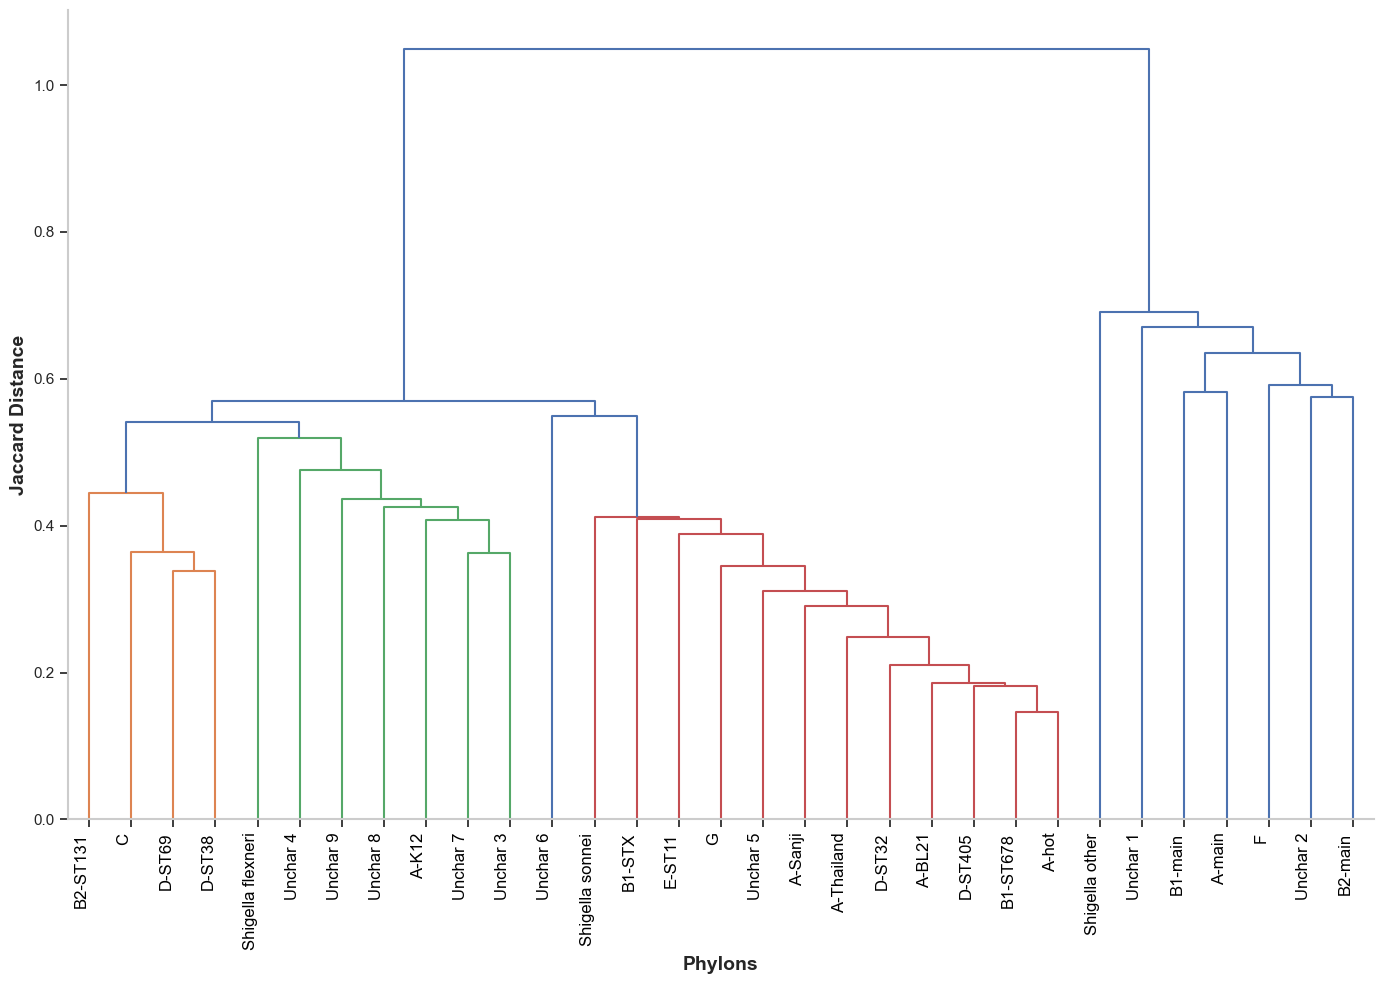

In [86]:
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from matplotlib import cm

# Combine all gene sets into a dictionary
gene_sets = {
    "Unchar 9": phylon_genes_unchar_9_genes,
    "Unchar 8": phylon_genes_unchar_8_genes,
    "Unchar 7": phylon_genes_unchar_7_genes,
    "Unchar 6": phylon_genes_unchar_6_genes,
    "Unchar 5": phylon_genes_unchar_5_genes,
    "Unchar 4": phylon_genes_unchar_4_genes,
    "Unchar 3": phylon_genes_unchar_3_genes,
    "Unchar 2": phylon_genes_unchar_2_genes,
    "Unchar 1": phylon_genes_unchar_1_genes,
    "Shigella flexneri": phylon_genes_Shigella_flexneri_genes,
    "Shigella other": phylon_genes_Shigella_dysenteriae_boydii_genes,
    "G": phylon_genes_phylon_G_genes,
    "F": phylon_genes_phylon_F_genes,
    "E-ST11": phylon_genes_E_ST11_genes,
    "D-ST69": phylon_genes_D_ST69_genes,
    "D-ST405": phylon_genes_D_ST405_genes,
    "D-ST38": phylon_genes_D_ST38_genes,
    "D-ST32": phylon_genes_D_ST32_genes,
    "C": phylon_genes_phylon_C_genes,
    "B2-main": phylon_genes_B2_other_genes,
    "B2-ST131": phylon_genes_B2_ST131_genes,
    "B1-main": phylon_genes_B1_other_genes,
    "B1-STX": phylon_genes_B1_ShigaToxin_genes,
    "B1-ST678": phylon_genes_B1_ST678_genes,
    "A-main": phylon_genes_A_other_genes,
    "A-hot": phylon_genes_A_hot_genes,
    "A-Thailand": phylon_genes_A_Thailand_genes,
    "A-Sanji": phylon_genes_A_Sanji_genes,
    "A-K12": phylon_genes_A_K12_genes,
    "Shigella sonnei": phylon_genes_Shigella_sonnei_genes,
    "A-BL21": phylon_genes_BL21_genes
}

# Get unique genes
all_genes = set()
for genes in gene_sets.values():
    all_genes.update(genes)
all_genes = list(all_genes)

# Create a binary matrix
gene_matrix = np.zeros((len(gene_sets), len(all_genes)))
for i, genes in enumerate(gene_sets.values()):
    for gene in genes:
        gene_matrix[i, all_genes.index(gene)] = 1

# Calculate the distance matrix
distance_matrix = pdist(gene_matrix, metric='Jaccard')

# Perform hierarchical clustering using the Ward method
linked = sch.linkage(distance_matrix, method='ward')

# Create the dendrogram plot
plt.figure(figsize=(14, 10))
dendro = sch.dendrogram(linked, labels=list(gene_sets.keys()), orientation='top', leaf_rotation=90, leaf_font_size=14, color_threshold=0.5 * max(linked[:, 2]))

# Customize the appearance
#plt.title('Phylogenetic Gene Dendrogram', fontsize=18, fontweight='bold')
plt.xlabel('Phylons', fontsize=14, fontweight='bold')
plt.ylabel('Jaccard Distance', fontsize=14, fontweight='bold')
plt.grid(False)

# Add color to the dendrogram branches
ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_fontsize(12)
    label.set_rotation(90)
    label.set_ha('right')
    label.set_color('black')

# Customize the axes and spines
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
"""
# Add a legend
legend_patches = [plt.Line2D([0], [0], color=cm.rainbow(i/10), lw=2) for i in range(10)]
ax.legend(legend_patches, [f'Cluster {i+1}' for i in range(10)], loc='upper right', frameon=False, fontsize='small')
"""
# Show the plot
#plt.savefig('/Users/omidard/Desktop/gem_phylon_distances.svg', dpi=800, bbox_inches='tight')
#plt.savefig('/Users/omidard/Desktop/gem_phylon_distances.png', dpi=800, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [87]:
for k in gene_sets.keys():
    print(k,' total metbolic gene count','=',len(gene_sets[k]))

Unchar 9  total metbolic gene count = 2301
Unchar 8  total metbolic gene count = 2388
Unchar 7  total metbolic gene count = 2142
Unchar 6  total metbolic gene count = 1967
Unchar 5  total metbolic gene count = 1977
Unchar 4  total metbolic gene count = 2661
Unchar 3  total metbolic gene count = 2234
Unchar 2  total metbolic gene count = 3241
Unchar 1  total metbolic gene count = 5308
Shigella flexneri  total metbolic gene count = 2436
Shigella other  total metbolic gene count = 3124
G  total metbolic gene count = 1930
F  total metbolic gene count = 3039
E-ST11  total metbolic gene count = 2086
D-ST69  total metbolic gene count = 2116
D-ST405  total metbolic gene count = 1658
D-ST38  total metbolic gene count = 2134
D-ST32  total metbolic gene count = 1590
C  total metbolic gene count = 2135
B2-main  total metbolic gene count = 3138
B2-ST131  total metbolic gene count = 2497
B1-main  total metbolic gene count = 3765
B1-STX  total metbolic gene count = 2084
B1-ST678  total metbolic gene 

/var/folders/g4/gzd2bm953vs0rn_qkz4wyd1w0000gp/T/ipykernel_25977/1299383280.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(
/var/folders/g4/gzd2bm953vs0rn_qkz4wyd1w0000gp/T/ipykernel_25977/1299383280.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)


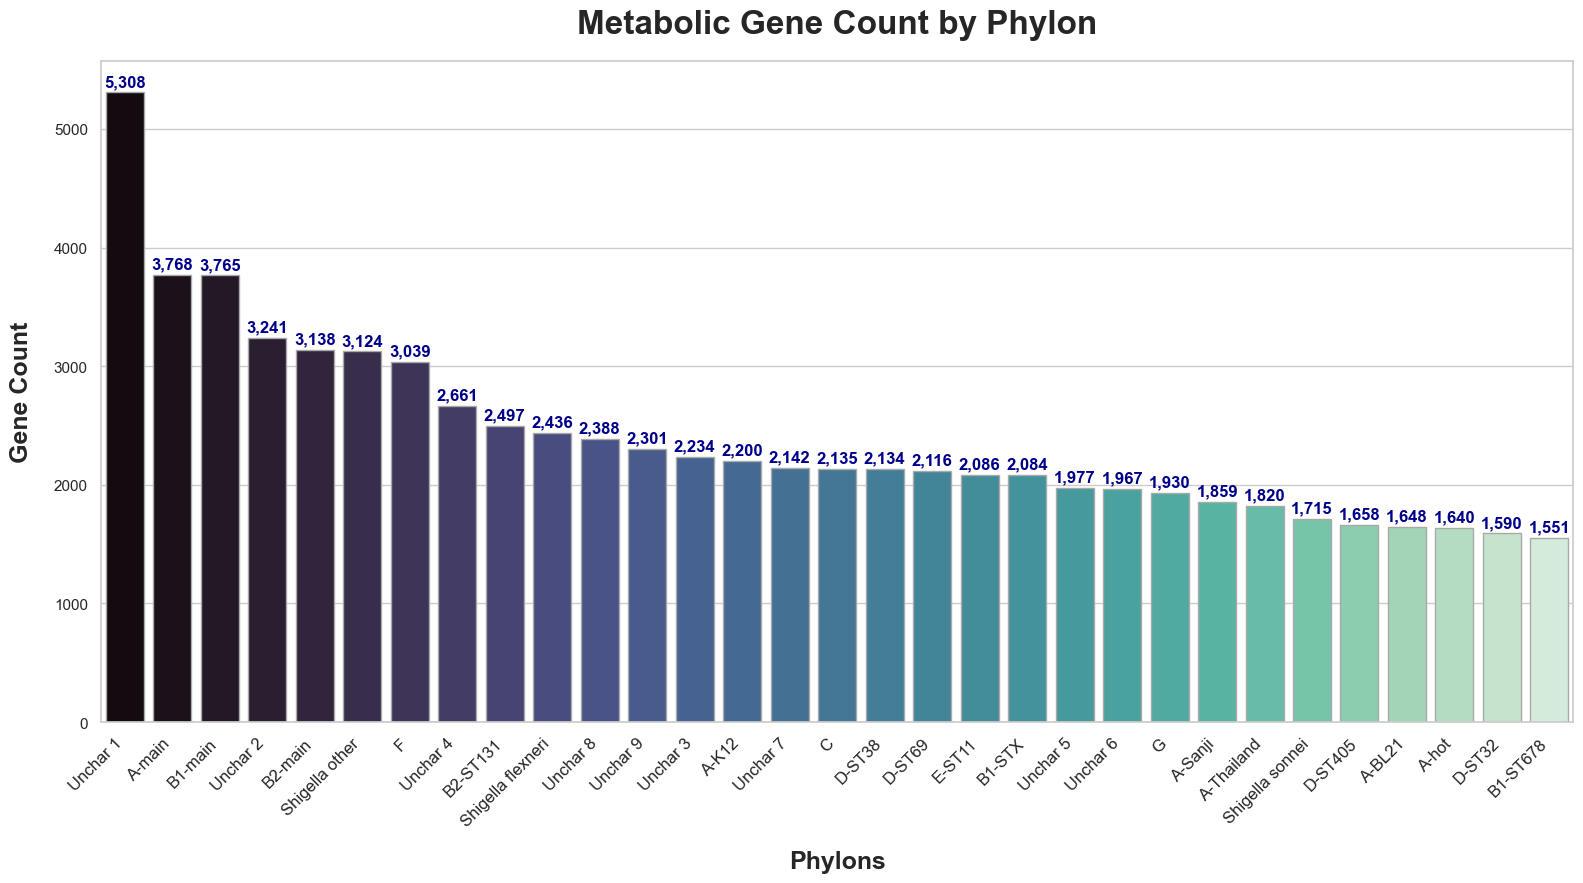

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

phylons = list(gene_sets.keys())
gene_counts = [len(gene_sets[k]) for k in phylons]

# Create a DataFrame and sort it by gene count in descending order
data_df = pd.DataFrame({'Phylon': phylons, 'Gene Count': gene_counts})
data_df = data_df.sort_values(by='Gene Count', ascending=False)

# Set up the figure with a refined, professional style
plt.figure(figsize=(16, 9))
sns.set_theme(style="whitegrid")

# Create the bar plot with an elegant color palette
bar_plot = sns.barplot(
    x='Phylon', 
    y='Gene Count', 
    data=data_df, 
    palette="mako", 
    edgecolor="darkgray"
)
bar_plot.set_title("Metabolic Gene Count by Phylon", fontsize=24, weight="bold", pad=20)
bar_plot.set_xlabel("Phylons", fontsize=18, weight="bold", labelpad=15)
bar_plot.set_ylabel("Gene Count", fontsize=18, weight="bold", labelpad=15)

# Customize x-axis labels for readability
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)

# Display values on top of each bar
for p in bar_plot.patches:
    bar_plot.annotate(
        f'{int(p.get_height()):,}',  # formatted as thousands separator if needed
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', 
        xytext=(0, 8), 
        textcoords='offset points', 
        fontsize=12, fontweight="bold", color="darkblue"
    )

# Add gridlines only on y-axis for a clean look
bar_plot.yaxis.grid(True)
bar_plot.xaxis.grid(False)

# Final layout adjustments and display
plt.tight_layout()
plt.show()


In [91]:
grouped = filtered_df.groupby('primary_phylon').size().reset_index(name='counts')

# Print out the results
for index, row in grouped.iterrows():
    print(f"{row['primary_phylon']} Phylon, GEMs Count: {row['counts']}")

A-BL21 Phylon, GEMs Count: 39
A-K12 Phylon, GEMs Count: 212
A-Sanji Phylon, GEMs Count: 66
A-Thailand Phylon, GEMs Count: 44
A-hot Phylon, GEMs Count: 23
A-other Phylon, GEMs Count: 213
B1-ST678 Phylon, GEMs Count: 17
B1-ShigaToxin Phylon, GEMs Count: 52
B1-other Phylon, GEMs Count: 321
B2-ST131 Phylon, GEMs Count: 121
B2-other Phylon, GEMs Count: 177
C Phylon, GEMs Count: 59
D-ST32 Phylon, GEMs Count: 18
D-ST38 Phylon, GEMs Count: 70
D-ST405 Phylon, GEMs Count: 30
D-ST69 Phylon, GEMs Count: 49
E-ST11 Phylon, GEMs Count: 224
F Phylon, GEMs Count: 59
G Phylon, GEMs Count: 20
Shigella-dysenteriae-boydii Phylon, GEMs Count: 30
Shigella-flexneri Phylon, GEMs Count: 55
Shigella-sonnei Phylon, GEMs Count: 38
unchar-1 Phylon, GEMs Count: 83
unchar-2 Phylon, GEMs Count: 52
unchar-3 Phylon, GEMs Count: 22
unchar-4 Phylon, GEMs Count: 43
unchar-5 Phylon, GEMs Count: 31
unchar-6 Phylon, GEMs Count: 2
unchar-7 Phylon, GEMs Count: 32
unchar-8 Phylon, GEMs Count: 27
unchar-9 Phylon, GEMs Count: 19


In [93]:
import pandas as pd

# Create an empty dictionary to store the counts
reactions_genes_variation_dict = {}
average_genes_per_cell_dict = {}

filtered_df2 = filtered_df.copy()
filtered_df2.fillna('NOTAGENE', inplace=True)

# Iterate over each column in the DataFrame
for column in filtered_df2.columns:
    unique_genes = set()
    total_genes = 0
    cell_count = 0
    for cell in filtered_df2[column]:
        if cell != 'NOTAGENE':
            unique_genes.update(cell)  # Add the genes to the set to avoid duplicates
            total_genes += len(cell)
            cell_count += 1
    reactions_genes_variation_dict[column] = len(unique_genes)
    if cell_count > 0:
        average_genes_per_cell_dict[column] = total_genes / cell_count
    else:
        average_genes_per_cell_dict[column] = 0

# Convert the dictionaries to a DataFrame
reactions_genes_variation = pd.DataFrame({
    'Reaction': list(reactions_genes_variation_dict.keys()),
    'Unique_Genes_Count': list(reactions_genes_variation_dict.values()),
    'Average_Genes_Per_Cell': list(average_genes_per_cell_dict.values())
})

reactions_genes_variation = reactions_genes_variation.sort_values(by='Unique_Genes_Count', ascending=False)

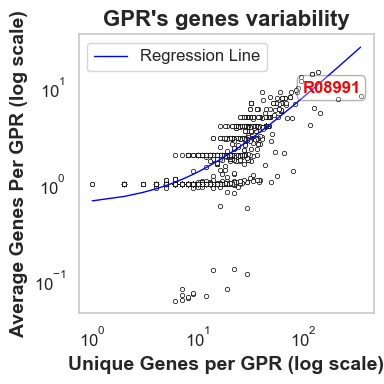

Slope (Rate of change): 0.07444820313467648
Intercept: 0.5996747104834641


In [95]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Extract the relevant columns
X = reactions_genes_variation['Unique_Genes_Count'].values.reshape(-1, 1)
y = reactions_genes_variation['Average_Genes_Per_Cell'].values

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the regression line
y_pred = model.predict(X)

# Plot the scatter plot
plt.figure(figsize=(4, 4))
scatter = plt.scatter(
    reactions_genes_variation['Unique_Genes_Count'], reactions_genes_variation['Average_Genes_Per_Cell'], 
    s=10, color='white', edgecolor='black', linewidth=0.5
)

# Plot the regression line
plt.plot(reactions_genes_variation['Unique_Genes_Count'], y_pred, color='blue', linewidth=1, label='Regression Line')

# Customize the plot
plt.title("GPR's genes variability", fontsize=16, fontweight='bold')
plt.xlabel('Unique Genes per GPR (log scale)', fontsize=14, fontweight='bold')
plt.ylabel('Average Genes Per GPR (log scale)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_facecolor('white')
plt.gca().grid(False)
plt.legend(fontsize=12)

# Set the x and y axis to log scale
plt.xscale('log')
plt.yscale('log')

# Annotate the top four dots with the highest unique genes count
top_3 = reactions_genes_variation.nlargest(1, 'Unique_Genes_Count')
for i, row in top_3.iterrows():
    plt.annotate(
        row['Reaction'], (row['Unique_Genes_Count'], row['Average_Genes_Per_Cell']),
        fontsize=12, fontweight='bold', color='red', 
        ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white', alpha=0.3)
    )

# Show the plot
plt.tight_layout()
plt.savefig('/Users/omidard/Desktop/reactions_unique_genes.png', dpi=800, bbox_inches='tight')
plt.show()

# Print the slope and intercept of the regression line
slope = model.coef_[0]
intercept = model.intercept_
print(f"Slope (Rate of change): {slope}")
print(f"Intercept: {intercept}")


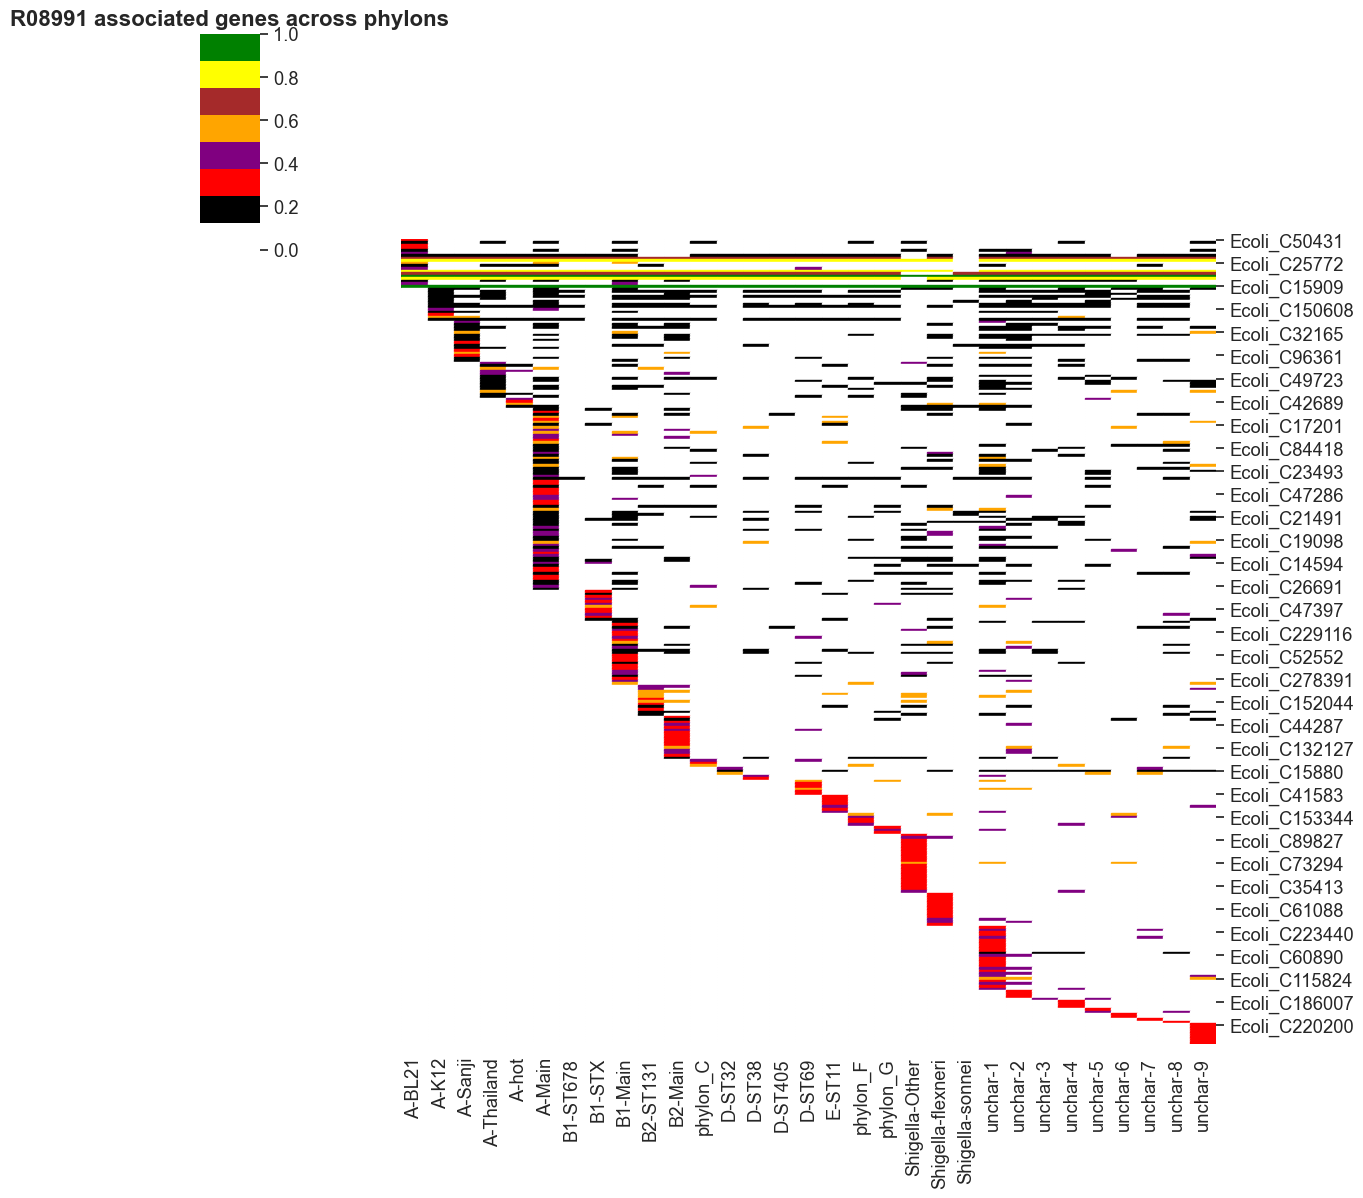

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tqdm import tqdm


def generate_cluster_map(reaction):
    # Extract the data for the specified reaction
    phylon_genes_reaction = phylon_genes[reaction]

    # Calculate the presence of each gene across phylons
    gene_presence = {}
    for phylon, genes in phylon_genes_reaction.items():
        unique_genes = set(genes)  # Remove duplicates within the same phylon
        for gene in unique_genes:
            if gene not in gene_presence:
                gene_presence[gene] = 0
            gene_presence[gene] += 1

    # Create a binary DataFrame indicating the presence of each gene in each phylon
    genes = list(gene_presence.keys())
    phylons = phylon_genes_reaction.keys()
    data = {phylon: [1 if gene in phylon_genes_reaction[phylon] else 0 for gene in genes] for phylon in phylons}

    binary_df = pd.DataFrame(data, index=genes)
    
    return binary_df, gene_presence

# Generate the binary DataFrame for reaction 'R08991'
binary_df, gene_presence = generate_cluster_map('R08991')

columns = []
for i in binary_df.columns:
    if i == 'A-other':
        columns.append('A-Main')
    elif i == 'B1-ShigaToxin':
        columns.append('B1-STX')
    elif i == 'B1-other':
        columns.append('B1-Main')
    elif i == 'B2-other':
        columns.append('B2-Main')
    elif i == 'Shigella-dysenteriae-boydii':
        columns.append('Shigella-Other')
    else:
        columns.append(i)
binary_df.columns = columns

# Function to apply the custom color map
def custom_color_map(gene, value):
    if value == 0:
        return 'white'
    presence_count = gene_presence[gene]
    if presence_count == 1:
        return 'red'
    elif presence_count == 2:
        return 'purple'
    elif presence_count == 3:
        return 'orange'
    elif presence_count == 29:
        return 'brown'
    elif presence_count == 30:
        return 'yellow'
    elif presence_count == 31:
        return 'green'
    else:
        return 'black'

# Create a clustermap with column clustering turned off
sns.set(font_scale=1.2)
g = sns.clustermap(binary_df, row_cluster=False, col_cluster=False, method='ward', metric='jaccard',
                   figsize=(12, 12), linewidths=0.5, linecolor='black', cmap=sns.color_palette(['white', 'black', 'red', 'purple', 'orange', 'brown', 'yellow', 'green'], as_cmap=True))

# Apply custom color mapping to the heatmap
for (i, j), val in np.ndenumerate(binary_df.values):
    g.ax_heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=custom_color_map(binary_df.index[i], val)))

# Set the xticklabels correctly
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)

# Remove y-tick labels
#g.ax_heatmap.set_yticklabels([])

plt.title('R08991 associated genes across phylons', fontsize=16, fontweight='bold')
#plt.savefig('/Users/omidard/Desktop/EcolipanGEM_final_panels/raw/R08991_verified_no_col_cluster.svg', dpi=300, bbox_inches='tight')
plt.show()

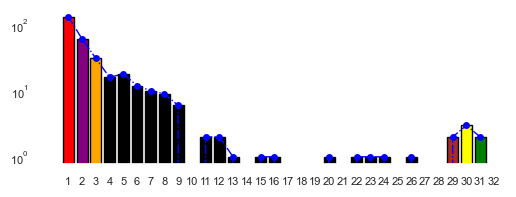

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Transpose the DataFrame
binary_df_transposed = binary_df.T

# Calculate the sum for each column
column_sums = binary_df_transposed.sum()

# Prepare for the histogram
plt.figure(figsize=(6, 2))
bins = np.arange(min(column_sums), max(column_sums) + 2) - 0.5

# Count frequencies of each count
counts = pd.Series(column_sums).value_counts().reindex(np.arange(min(column_sums), max(column_sums) + 1), fill_value=0)

# Bar colors based on x-tick labels
colors = []
for count in counts.index:
    if count == 1:
        colors.append('red')
    elif count == 2:
        colors.append('purple')
    elif count == 3:
        colors.append('orange')
    elif count == 29:
        colors.append('brown')
    elif count == 30:
        colors.append('yellow')
    elif count == 31:
        colors.append('green')
    else:
        colors.append('black')

# Plot the histogram
bars = plt.bar(counts.index, counts.values, color=colors, edgecolor='black', align='center')

# Remove axis labels
plt.xlabel('')
plt.ylabel('')

# Draw a line that follows the bar curve
mid_points = [(bar.get_x() + bar.get_width()/2) for bar in bars]
plt.plot(mid_points, counts.values, color='blue', marker='o', markersize=4, linestyle='-.', linewidth=1)

# Customize x-ticks
plt.xticks(bins + 0.5)  # Ensure x-ticks cover all possible counts
plt.tick_params(axis='both', which='major', labelsize=8)

#plt.xscale('log')
plt.yscale('log')

# Hide gridlines
plt.grid(False)

# Set background to white
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Show the plot
#plt.savefig('/Users/omidard/Desktop/R08991_histo.svg', dpi=300, bbox_inches='tight')
plt.show()


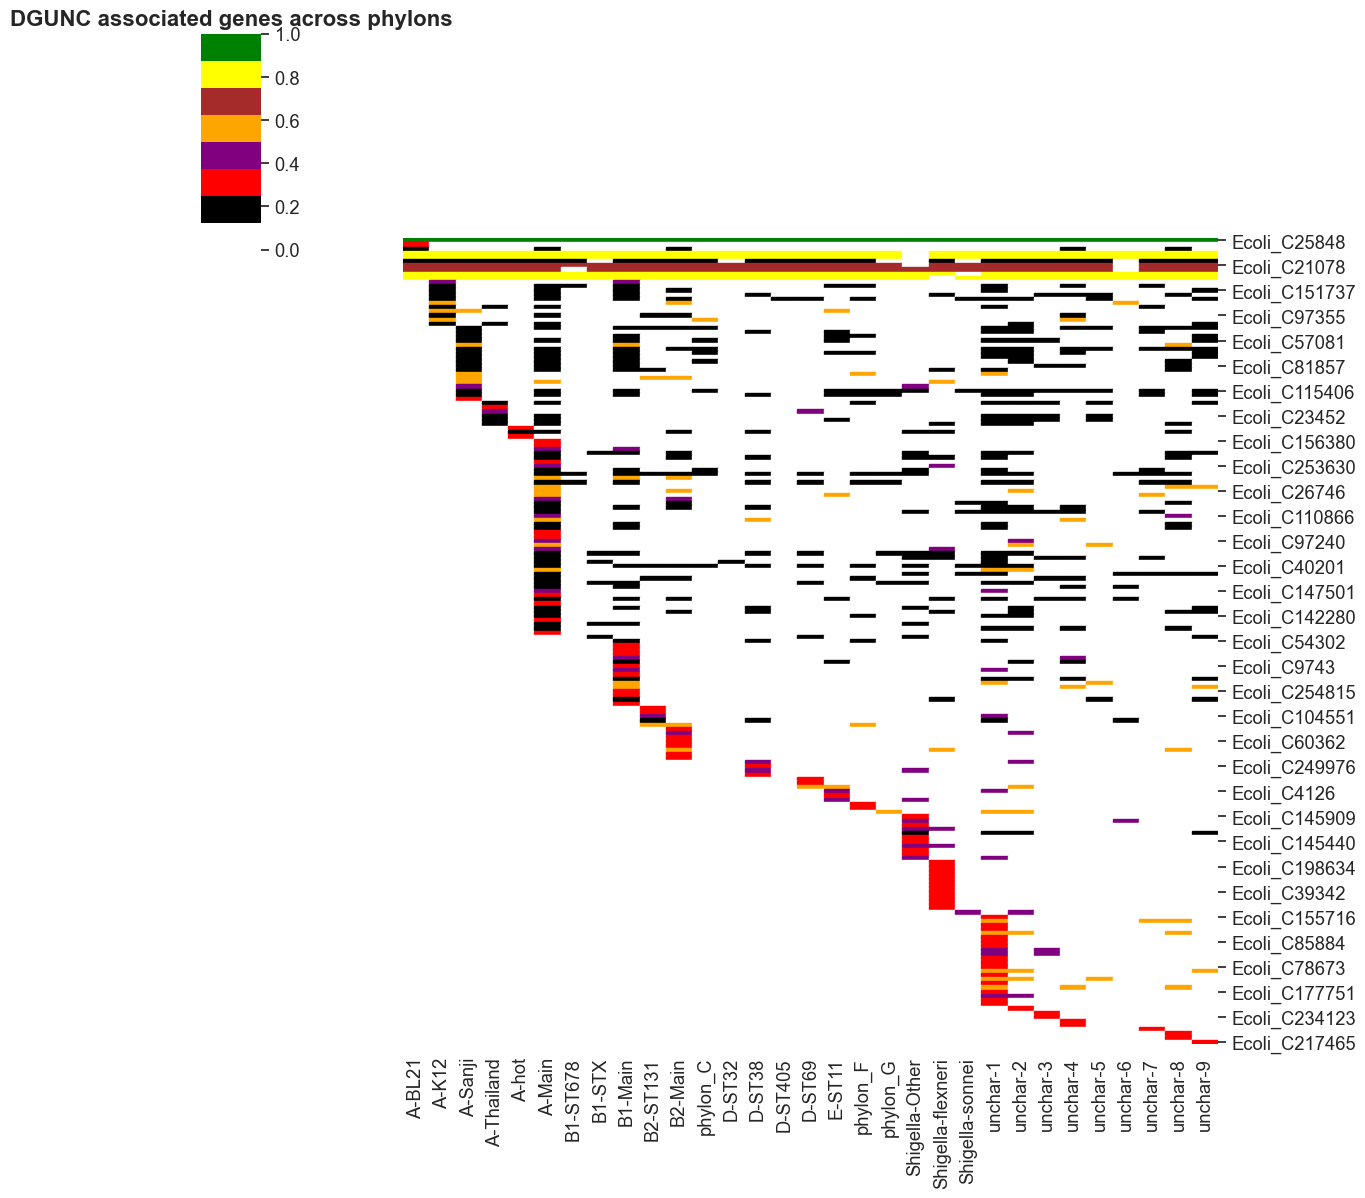

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tqdm import tqdm

def generate_cluster_map(reaction):
    # Extract the data for the specified reaction
    phylon_genes_reaction = phylon_genes[reaction]

    # Calculate the presence of each gene across phylons
    gene_presence = {}
    for phylon, genes in phylon_genes_reaction.items():
        unique_genes = set(genes)  # Remove duplicates within the same phylon
        for gene in unique_genes:
            if gene not in gene_presence:
                gene_presence[gene] = 0
            gene_presence[gene] += 1

    # Create a binary DataFrame indicating the presence of each gene in each phylon
    genes = list(gene_presence.keys())
    phylons = phylon_genes_reaction.keys()
    data = {phylon: [1 if gene in phylon_genes_reaction[phylon] else 0 for gene in genes] for phylon in phylons}

    binary_df = pd.DataFrame(data, index=genes)
    
    return binary_df, gene_presence

# Generate the binary DataFrame for reaction 'DGUNC'
binary_df, gene_presence = generate_cluster_map('DGUNC')

columns = []
for i in binary_df.columns:
    if i == 'A-other':
        columns.append('A-Main')
    elif i == 'B1-ShigaToxin':
        columns.append('B1-STX')
    elif i == 'B1-other':
        columns.append('B1-Main')
    elif i == 'B2-other':
        columns.append('B2-Main')
    elif i == 'Shigella-dysenteriae-boydii':
        columns.append('Shigella-Other')
    else:
        columns.append(i)
binary_df.columns = columns

# Function to apply the custom color map
def custom_color_map(gene, value):
    if value == 0:
        return 'white'
    presence_count = gene_presence[gene]
    if presence_count == 1:
        return 'red'
    elif presence_count == 2:
        return 'purple'
    elif presence_count == 3:
        return 'orange'
    elif presence_count == 29:
        return 'brown'
    elif presence_count == 30:
        return 'yellow'
    elif presence_count == 31:
        return 'green'
    else:
        return 'black'

# Create a clustermap with column clustering turned off
sns.set(font_scale=1.2)
g = sns.clustermap(binary_df, row_cluster=False, col_cluster=False, method='ward', metric='jaccard',
                   figsize=(12, 12), linewidths=0.5, linecolor='black', cmap=sns.color_palette(['white', 'black', 'red', 'purple', 'orange', 'brown', 'yellow', 'green'], as_cmap=True))

# Apply custom color mapping to the heatmap
for (i, j), val in np.ndenumerate(binary_df.values):
    g.ax_heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=custom_color_map(binary_df.index[i], val)))

# Set the xticklabels correctly
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)

# Remove y-tick labels
#g.ax_heatmap.set_yticklabels([])

plt.title('DGUNC associated genes across phylons', fontsize=16, fontweight='bold')
#plt.savefig('/Users/omidard/Desktop/EcolipanGEM_final_panels/raw/DGUNC_verified_no_col_cluster.svg', dpi=300, bbox_inches='tight')
plt.show()

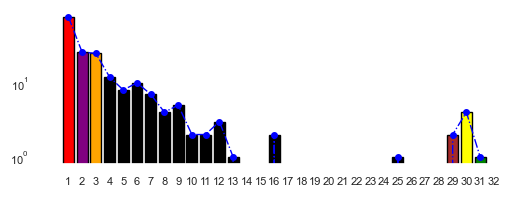

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Transpose the DataFrame
binary_df_transposed = binary_df.T

# Calculate the sum for each column
column_sums = binary_df_transposed.sum()

# Prepare for the histogram
plt.figure(figsize=(6, 2))
bins = np.arange(min(column_sums), max(column_sums) + 2) - 0.5

# Count frequencies of each count
counts = pd.Series(column_sums).value_counts().reindex(np.arange(min(column_sums), max(column_sums) + 1), fill_value=0)

# Bar colors based on x-tick labels
colors = []
for count in counts.index:
    if count == 1:
        colors.append('red')
    elif count == 2:
        colors.append('purple')
    elif count == 3:
        colors.append('orange')
    elif count == 29:
        colors.append('brown')
    elif count == 30:
        colors.append('yellow')
    elif count == 31:
        colors.append('green')
    else:
        colors.append('black')

# Plot the histogram
bars = plt.bar(counts.index, counts.values, color=colors, edgecolor='black', align='center')

# Remove axis labels
plt.xlabel('')
plt.ylabel('')

# Draw a line that follows the bar curve
mid_points = [(bar.get_x() + bar.get_width()/2) for bar in bars]
plt.plot(mid_points, counts.values, color='blue', marker='o', markersize=4, linestyle='-.', linewidth=1)

# Customize x-ticks
plt.xticks(bins + 0.5)  # Ensure x-ticks cover all possible counts
plt.tick_params(axis='both', which='major', labelsize=8)

#plt.xscale('log')
plt.yscale('log')

# Hide gridlines
plt.grid(False)

# Set background to white
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Show the plot
#plt.savefig('/Users/omidard/Desktop/R08991_histo.svg', dpi=300, bbox_inches='tight')
plt.show()


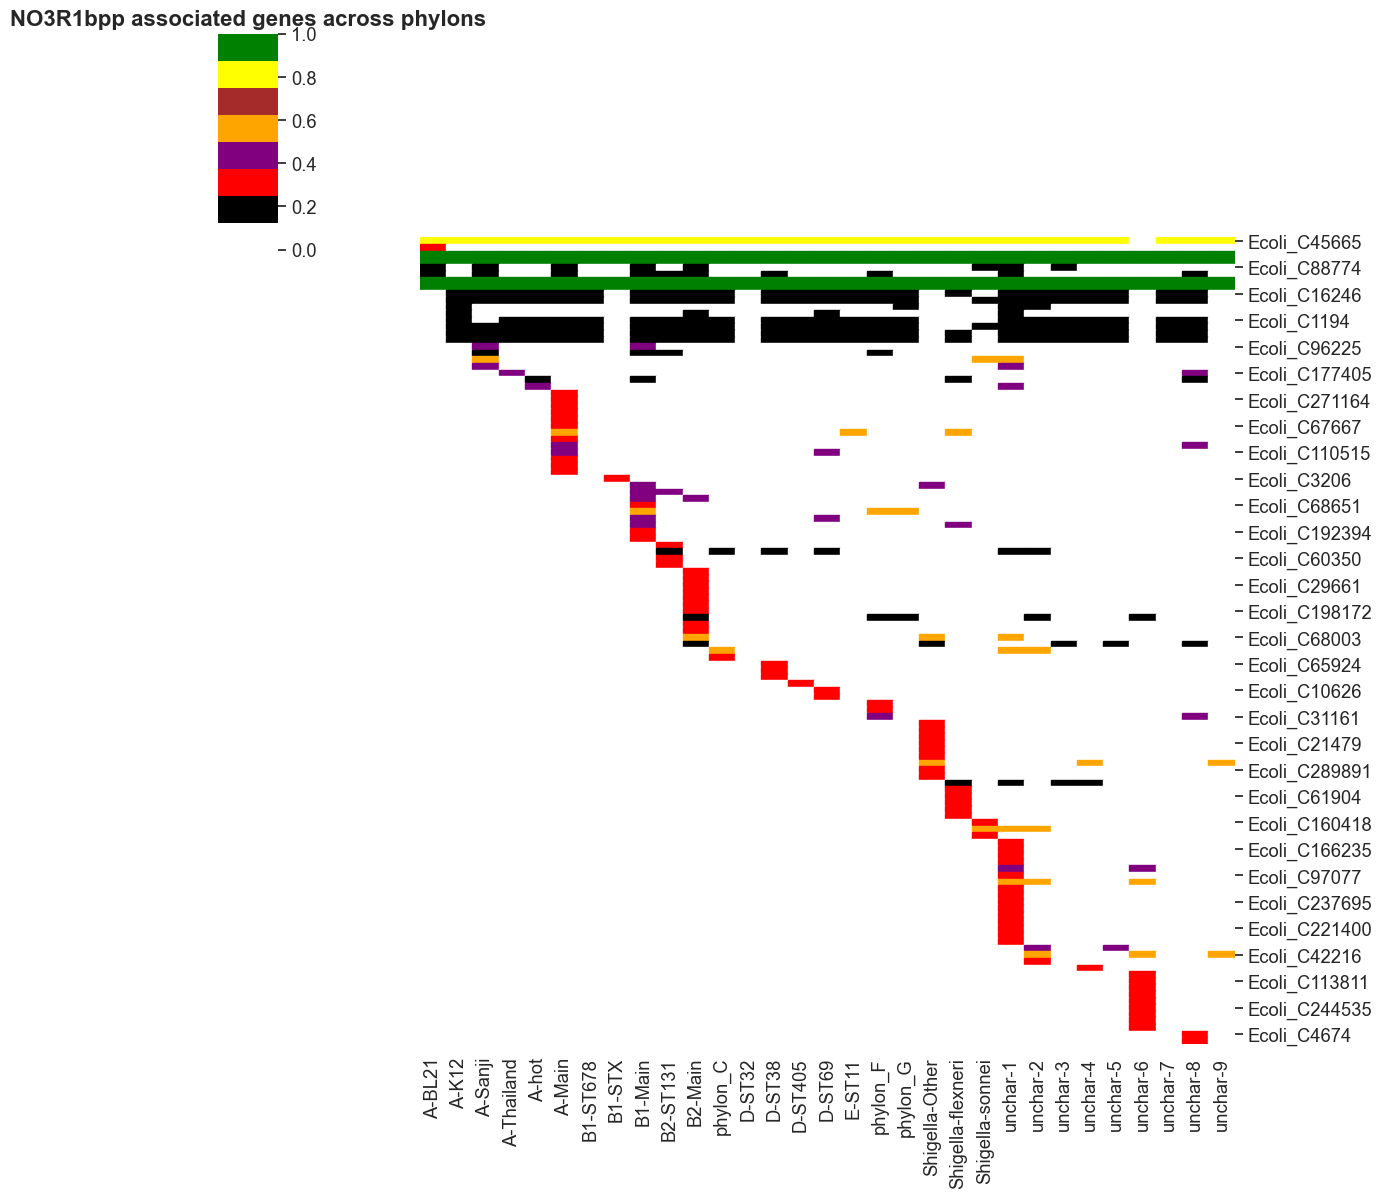

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tqdm import tqdm

def generate_cluster_map(reaction):
    # Extract the data for the specified reaction
    phylon_genes_reaction = phylon_genes[reaction]

    # Calculate the presence of each gene across phylons
    gene_presence = {}
    for phylon, genes in phylon_genes_reaction.items():
        unique_genes = set(genes)  # Remove duplicates within the same phylon
        for gene in unique_genes:
            if gene not in gene_presence:
                gene_presence[gene] = 0
            gene_presence[gene] += 1

    # Create a binary DataFrame indicating the presence of each gene in each phylon
    genes = list(gene_presence.keys())
    phylons = phylon_genes_reaction.keys()
    data = {phylon: [1 if gene in phylon_genes_reaction[phylon] else 0 for gene in genes] for phylon in phylons}

    binary_df = pd.DataFrame(data, index=genes)
    
    return binary_df, gene_presence

# Generate the binary DataFrame for reaction 'NO3R1bpp'
binary_df, gene_presence = generate_cluster_map('NO3R1bpp')

columns = []
for i in binary_df.columns:
    if i == 'A-other':
        columns.append('A-Main')
    elif i == 'B1-ShigaToxin':
        columns.append('B1-STX')
    elif i == 'B1-other':
        columns.append('B1-Main')
    elif i == 'B2-other':
        columns.append('B2-Main')
    elif i == 'Shigella-dysenteriae-boydii':
        columns.append('Shigella-Other')
    else:
        columns.append(i)
binary_df.columns = columns

# Function to apply the custom color map
def custom_color_map(gene, value):
    if value == 0:
        return 'white'
    presence_count = gene_presence[gene]
    if presence_count == 1:
        return 'red'
    elif presence_count == 2:
        return 'purple'
    elif presence_count == 3:
        return 'orange'
    elif presence_count == 29:
        return 'brown'
    elif presence_count == 30:
        return 'yellow'
    elif presence_count == 31:
        return 'green'
    else:
        return 'black'

# Create a clustermap with column clustering turned off
sns.set(font_scale=1.2)
g = sns.clustermap(binary_df, row_cluster=False, col_cluster=False, method='ward', metric='jaccard',
                   figsize=(12, 12), linewidths=0.5, linecolor='black', cmap=sns.color_palette(['white', 'black', 'red', 'purple', 'orange', 'brown', 'yellow', 'green'], as_cmap=True))

# Apply custom color mapping to the heatmap
for (i, j), val in np.ndenumerate(binary_df.values):
    g.ax_heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=custom_color_map(binary_df.index[i], val)))

# Set the xticklabels correctly
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)

# Remove y-tick labels
#g.ax_heatmap.set_yticklabels([])

plt.title('NO3R1bpp associated genes across phylons', fontsize=16, fontweight='bold')
#plt.savefig('/Users/omidard/Desktop/EcolipanGEM_final_panels/raw/NO3R1bpp_verified_no_col_cluster.svg', dpi=300, bbox_inches='tight')
plt.show()

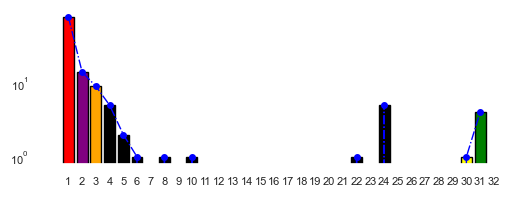

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Transpose the DataFrame
binary_df_transposed = binary_df.T

# Calculate the sum for each column
column_sums = binary_df_transposed.sum()

# Prepare for the histogram
plt.figure(figsize=(6, 2))
bins = np.arange(min(column_sums), max(column_sums) + 2) - 0.5

# Count frequencies of each count
counts = pd.Series(column_sums).value_counts().reindex(np.arange(min(column_sums), max(column_sums) + 1), fill_value=0)

# Bar colors based on x-tick labels
colors = []
for count in counts.index:
    if count == 1:
        colors.append('red')
    elif count == 2:
        colors.append('purple')
    elif count == 3:
        colors.append('orange')
    elif count == 29:
        colors.append('brown')
    elif count == 30:
        colors.append('yellow')
    elif count == 31:
        colors.append('green')
    else:
        colors.append('black')

# Plot the histogram
bars = plt.bar(counts.index, counts.values, color=colors, edgecolor='black', align='center')

# Remove axis labels
plt.xlabel('')
plt.ylabel('')

# Draw a line that follows the bar curve
mid_points = [(bar.get_x() + bar.get_width()/2) for bar in bars]
plt.plot(mid_points, counts.values, color='blue', marker='o', markersize=4, linestyle='-.', linewidth=1)

# Customize x-ticks
plt.xticks(bins + 0.5)  # Ensure x-ticks cover all possible counts
plt.tick_params(axis='both', which='major', labelsize=8)

#plt.xscale('log')
plt.yscale('log')

# Hide gridlines
plt.grid(False)

# Set background to white
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Show the plot
#plt.savefig('/Users/omidard/Desktop/R08991_histo.svg', dpi=300, bbox_inches='tight')
plt.show()


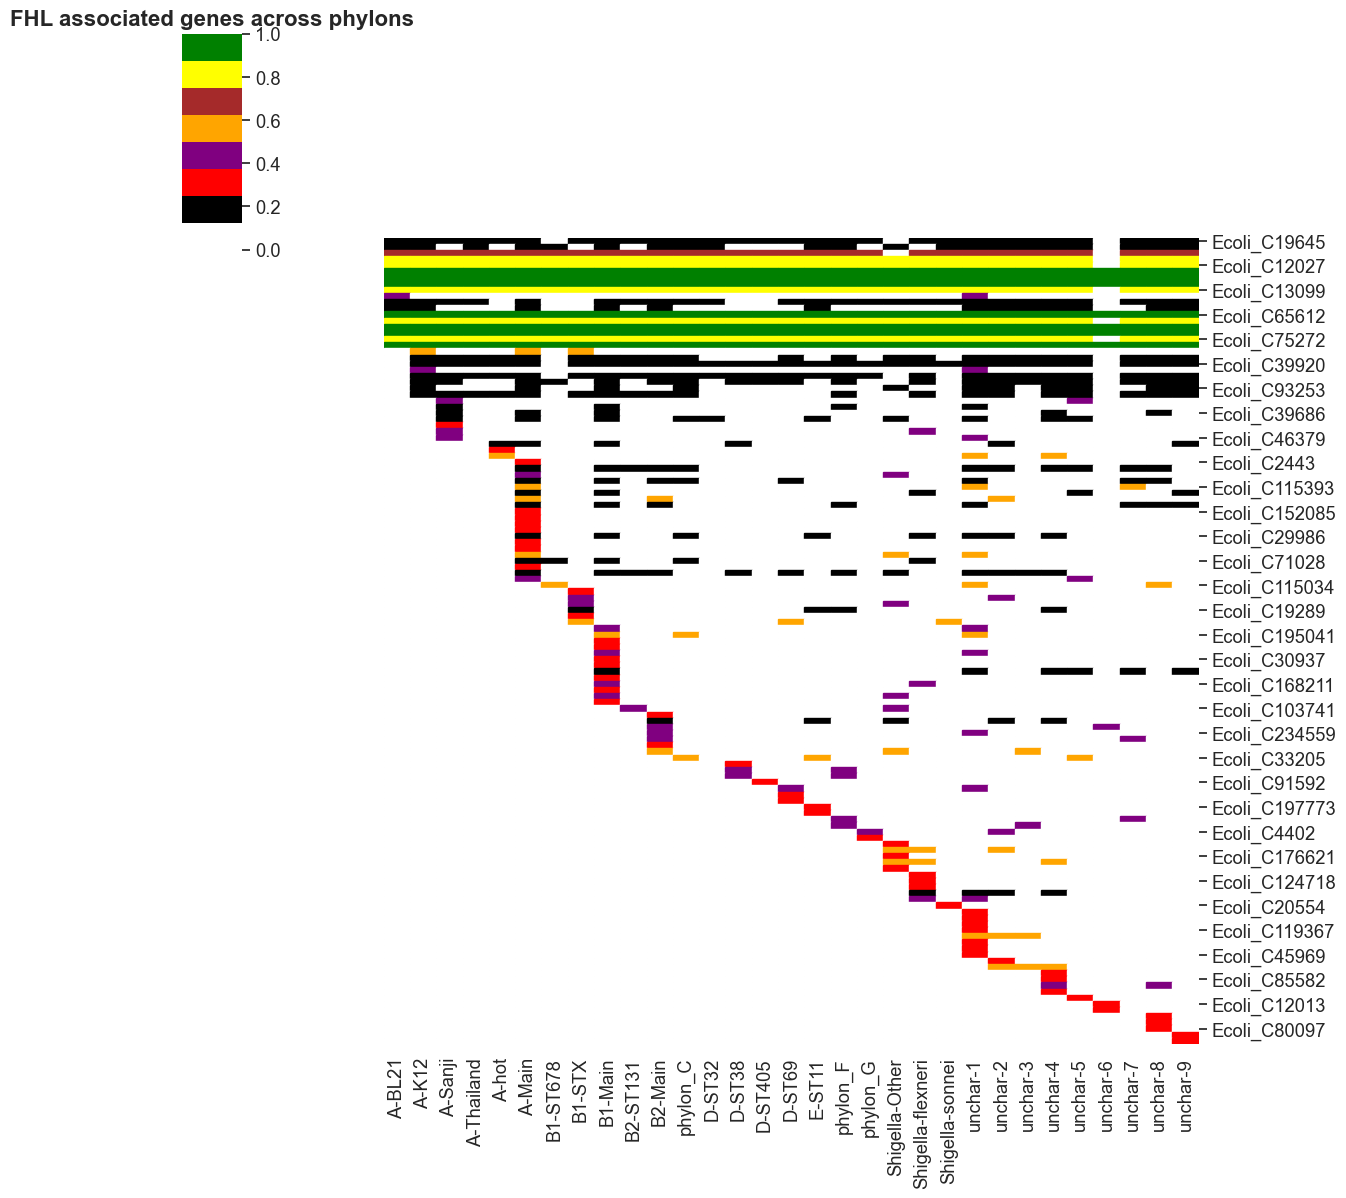

In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tqdm import tqdm

def generate_cluster_map(reaction):
    # Extract the data for the specified reaction
    phylon_genes_reaction = phylon_genes[reaction]

    # Calculate the presence of each gene across phylons
    gene_presence = {}
    for phylon, genes in phylon_genes_reaction.items():
        unique_genes = set(genes)  # Remove duplicates within the same phylon
        for gene in unique_genes:
            if gene not in gene_presence:
                gene_presence[gene] = 0
            gene_presence[gene] += 1

    # Create a binary DataFrame indicating the presence of each gene in each phylon
    genes = list(gene_presence.keys())
    phylons = phylon_genes_reaction.keys()
    data = {phylon: [1 if gene in phylon_genes_reaction[phylon] else 0 for gene in genes] for phylon in phylons}

    binary_df = pd.DataFrame(data, index=genes)
    
    return binary_df, gene_presence

# Generate the binary DataFrame for reaction 'FHL'
binary_df, gene_presence = generate_cluster_map('FHL')

columns = []
for i in binary_df.columns:
    if i == 'A-other':
        columns.append('A-Main')
    elif i == 'B1-ShigaToxin':
        columns.append('B1-STX')
    elif i == 'B1-other':
        columns.append('B1-Main')
    elif i == 'B2-other':
        columns.append('B2-Main')
    elif i == 'Shigella-dysenteriae-boydii':
        columns.append('Shigella-Other')
    else:
        columns.append(i)
binary_df.columns = columns

# Function to apply the custom color map
def custom_color_map(gene, value):
    if value == 0:
        return 'white'
    presence_count = gene_presence[gene]
    if presence_count == 1:
        return 'red'
    elif presence_count == 2:
        return 'purple'
    elif presence_count == 3:
        return 'orange'
    elif presence_count == 29:
        return 'brown'
    elif presence_count == 30:
        return 'yellow'
    elif presence_count == 31:
        return 'green'
    else:
        return 'black'

# Create a clustermap with column clustering turned off
sns.set(font_scale=1.2)
g = sns.clustermap(binary_df, row_cluster=False, col_cluster=False, method='ward', metric='jaccard',
                   figsize=(12, 12), linewidths=0.5, linecolor='black', cmap=sns.color_palette(['white', 'black', 'red', 'purple', 'orange', 'brown', 'yellow', 'green'], as_cmap=True))

# Apply custom color mapping to the heatmap
for (i, j), val in np.ndenumerate(binary_df.values):
    g.ax_heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=custom_color_map(binary_df.index[i], val)))

# Set the xticklabels correctly
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)

# Remove y-tick labels
#g.ax_heatmap.set_yticklabels([])

plt.title('FHL associated genes across phylons', fontsize=16, fontweight='bold')
#plt.savefig('/Users/omidard/Desktop/EcolipanGEM_final_panels/raw/FHL_verified_no_col_cluster.svg', dpi=300, bbox_inches='tight')
plt.show()

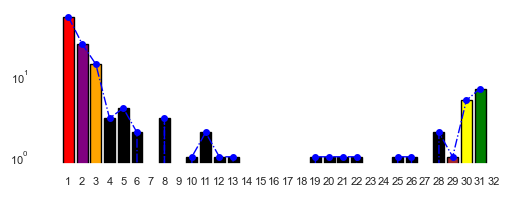

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Transpose the DataFrame
binary_df_transposed = binary_df.T

# Calculate the sum for each column
column_sums = binary_df_transposed.sum()

# Prepare for the histogram
plt.figure(figsize=(6, 2))
bins = np.arange(min(column_sums), max(column_sums) + 2) - 0.5

# Count frequencies of each count
counts = pd.Series(column_sums).value_counts().reindex(np.arange(min(column_sums), max(column_sums) + 1), fill_value=0)

# Bar colors based on x-tick labels
colors = []
for count in counts.index:
    if count == 1:
        colors.append('red')
    elif count == 2:
        colors.append('purple')
    elif count == 3:
        colors.append('orange')
    elif count == 29:
        colors.append('brown')
    elif count == 30:
        colors.append('yellow')
    elif count == 31:
        colors.append('green')
    else:
        colors.append('black')

# Plot the histogram
bars = plt.bar(counts.index, counts.values, color=colors, edgecolor='black', align='center')

# Remove axis labels
plt.xlabel('')
plt.ylabel('')

# Draw a line that follows the bar curve
mid_points = [(bar.get_x() + bar.get_width()/2) for bar in bars]
plt.plot(mid_points, counts.values, color='blue', marker='o', markersize=4, linestyle='-.', linewidth=1)

# Customize x-ticks
plt.xticks(bins + 0.5)  # Ensure x-ticks cover all possible counts
plt.tick_params(axis='both', which='major', labelsize=8)

#plt.xscale('log')
plt.yscale('log')

# Hide gridlines
plt.grid(False)

# Set background to white
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Show the plot
#plt.savefig('/Users/omidard/Desktop/R08991_histo.svg', dpi=300, bbox_inches='tight')
plt.show()


### Gene neighborhood analysis core/accessory vs rare genes
---

Run following scripts sequentually in terminal
---
1- genes_neighborhood_analysis_total_preparation.py 

2- genes_neighborhood_analysis_total2.py

In [113]:
# Load the output datafram (all_reactions_gene_neighborhood.csv) produced by genes_neighborhood_analysis_total2.py

import pandas as pd
import re

# Define the file path
file_path = '/Users/omidard/Desktop/neighborhood/all_reactions_gene_neighborhood.csv'

# Load the CSV file into a DataFrame
ngn = pd.read_csv(file_path)
ngn.drop(columns=['Downstream_Gene_2','Upstream_Gene_2','reaction','genome_id'],inplace=True)
# Remove duplicated rows based on the 'locus_tag' column
ngn = ngn.drop_duplicates(subset=['locus_tag'])
ngn.drop(columns=['locus_tag'],inplace=True)

# Function to extract gene name
def extract_gene_name(value):
    # Regular expression to capture text after 'gene=' and stop at the next space or bracket
    match = re.search(r'gene=([^\s\]]+)', str(value))
    if match:
        return match.group(1)  # Return the captured gene name
    else:
        return value  # Return the original value if no gene= found

# Function to clean the DataFrame
def clean_gene_columns(df, columns):
    for col in columns:
        df[col] = df[col].apply(extract_gene_name)
    return df

# Define the columns to clean
columns_to_clean = ['Downstream_Gene_1', 'Target_Gene', 'Upstream_Gene_1']

# Clean the DataFrame
cleaned_ngn = clean_gene_columns(ngn.copy(), columns_to_clean)

# Display the cleaned DataFrame
cleaned_ngn


gene_name   category Downstream_Gene_1 Target_Gene  \
0         Ecoli_C33756  Accessory               ftp        ompC   
1         Ecoli_C34348  Accessory               crl        phoE   
2         Ecoli_C29968  Accessory              aspC        ompF   
3         Ecoli_C23968  Accessory              uspF        ompN   
4         Ecoli_C34348  Accessory               crl        phoE   
...                ...        ...               ...         ...   
10335769  Ecoli_C71430       Core              znuB        znuC   
10335770  Ecoli_C40265       Core              znuC        znuA   
10335771  Ecoli_C65914       Core              ruvB        znuB   
10335772  Ecoli_C71430       Core              znuB        znuC   
10335773  Ecoli_C40265       Core              znuC        znuA   

         Upstream_Gene_1   Reaction  
0                   rcsD  12PPDRtex  
1                   proB  12PPDRtex  
2                   asnS  12PPDRtex  
3                   ydbK  12PPDRtex  
4                   proB  12PPDRtex  
...                  ...        ...  
10335769            znuA    ZNabcpp  
10335770            mepM    ZNabcpp  
10335771            znuC    ZNabcpp  
10335772            znuA    ZNabcpp  
10335773            mepM    ZNabcpp  

[3264200 rows x 6 columns]

In [114]:
cleaned_ngn = cleaned_ngn[cleaned_ngn['Target_Gene']!='hypothetical protein']
grouped = cleaned_ngn.groupby('Target_Gene')
# Step 2: Create a list of DataFrames, one for each group
df_list = [group for _, group in grouped]

selected_dfs = []
# Iterate through each DataFrame in df_list
for df in df_list:
    # Check if the 'category' column has 2 or more unique values
    if len(df['category'].unique()) >= 2:
        if len(df) > 160:
            if df.category.value_counts().min() >1:
                selected_dfs.append(df)



# Function to process each DataFrame and calculate the required values
def process_df(df):
    # Group the DataFrame by 'category'
    grouped_df = df.groupby('category')
    
    # List to store results
    result_rows = []
    
    # Iterate over each group
    for category, group in grouped_df:
        # Calculate the neighbor_gene_per_occurrence
        neighbor_gene_per_occurrence = len(group['Downstream_Gene_1'].unique()) / len(group)
        
        # Get the occurrence count for each Target_Gene in this group
        target_gene_counts = group['Target_Gene'].value_counts()
        
        # Add a row for each Target_Gene in this group
        for target_gene in group['Target_Gene'].unique():
            gene_count = target_gene_counts[target_gene]  # Count of occurrences for the target gene
            result_rows.append({
                'Target_Gene': target_gene,
                'category': category,
                'neighbor_gene_per_occurrence': neighbor_gene_per_occurrence,
                'gene_count': gene_count  # Add the gene count column
            })
    
    return pd.DataFrame(result_rows)

# List to store the final results for all DataFrames
final_results = []

# Iterate over each DataFrame in selected_dfs
for df in selected_dfs:
    # Process the DataFrame and append the result to the final_results list
    processed_df = process_df(df)
    final_results.append(processed_df)

# Concatenate all the processed DataFrames into one final DataFrame
final_df = pd.concat(final_results, ignore_index=True)

# Optionally, you can save the DataFrame to a CSV file
#final_df.to_csv('neighbor_gene_per_occurrence.csv', index=False)

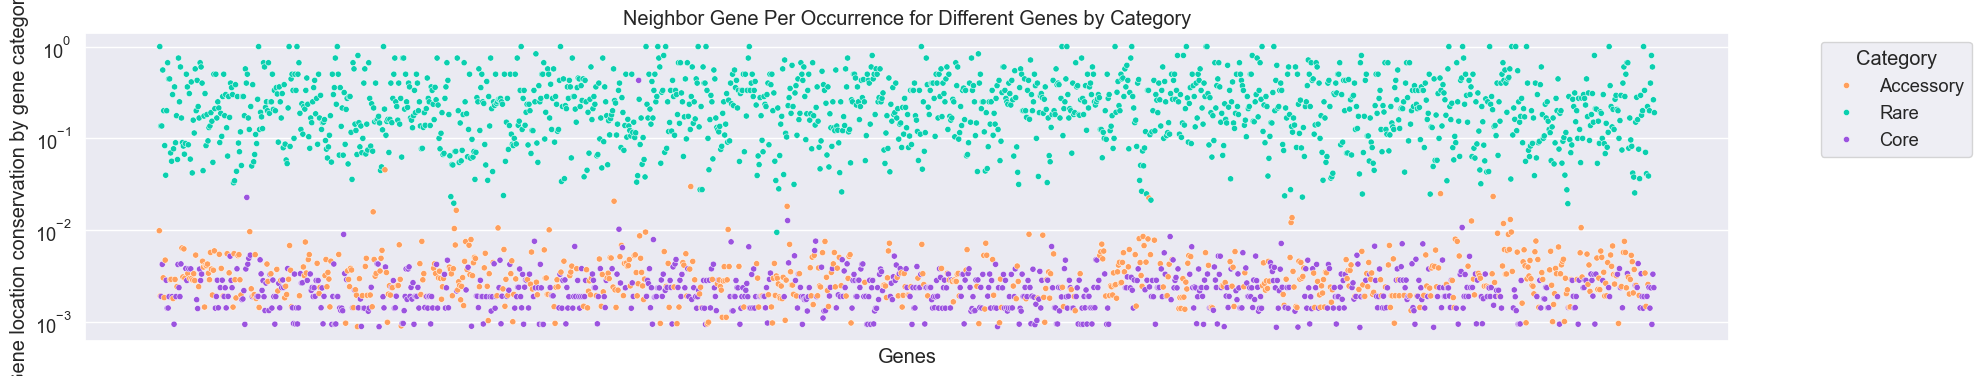

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(20, 4))

# Define a custom color palette
custom_palette = {
    'Accessory': '#ff9f5c',  # Orange for Accessory
    'Core': '#9b53df',       # Purple for Core
    'Rare': '#0acfaf'        # Turquoise for Rare
}

# Create a scatter plot using seaborn with the custom palette
sns.scatterplot(
    x=final_df.index,  # Use index for x-axis since the genes are too many to label
    y='neighbor_gene_per_occurrence',
    hue='category',  # Color by category
    data=final_df,
    palette=custom_palette,  # Use the custom color palette
    s=20  # Set marker size
)

# Hide the x-axis labels (since there are too many genes)
plt.xticks([], [])

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Set the axis labels and title
plt.xlabel('Genes')
plt.ylabel('Gene location conservation by gene category')
plt.title('Neighbor Gene Per Occurrence for Different Genes by Category')

# Show the legend and plot
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot
plt.tight_layout()
#plt.savefig('/Users/omidard/Desktop/gene_neighborhood.svg', dpi=800, bbox_inches='tight')

# Show the plot
plt.show()


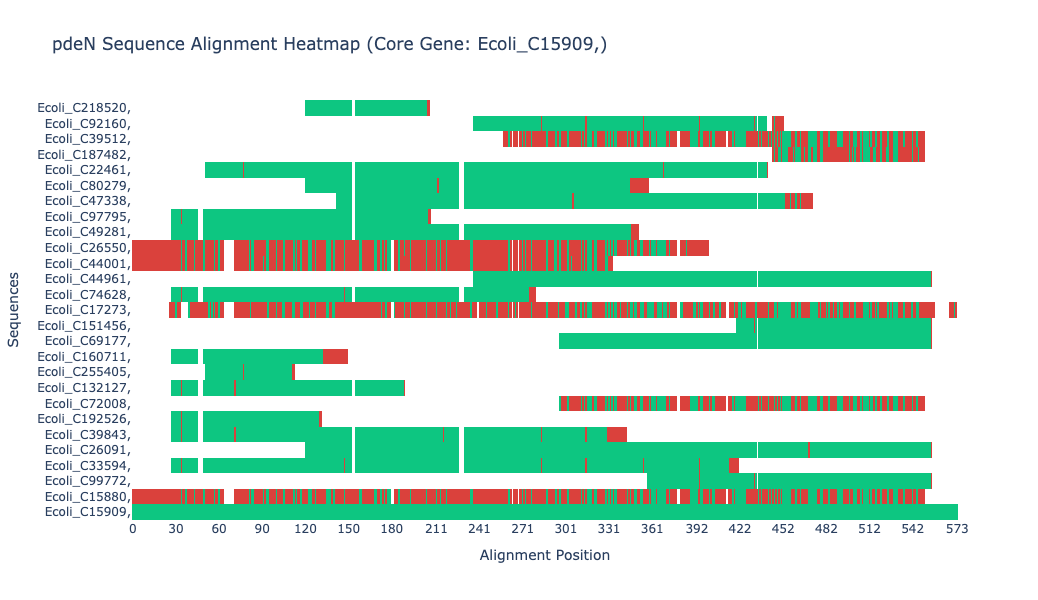

In [125]:
import os
import plotly.graph_objects as go
import numpy as np
from Bio import SeqIO, AlignIO
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Align.Applications import ClustalOmegaCommandline
import plotly.figure_factory as ff
import os
import tempfile
import numpy as np
import plotly.graph_objects as go



def load_largest_sequence_from_fasta(fasta_file):
    """Load the largest sequence from a given FASTA file."""
    sequences = list(SeqIO.parse(fasta_file, "fasta"))
    largest_sequence = max(sequences, key=lambda seq: len(seq.seq))
    return largest_sequence

def perform_multiple_sequence_alignment(sequences):
    """Perform MSA on a list of sequences using Clustal Omega."""
    with tempfile.NamedTemporaryFile(delete=False, suffix=".fasta") as temp_input, \
         tempfile.NamedTemporaryFile(delete=False, suffix=".aln") as temp_output:
        
        # Write the sequences to a temporary FASTA file
        SeqIO.write(sequences, temp_input.name, "fasta")
        
        # Run Clustal Omega for MSA with the --force option to overwrite existing files
        clustalomega_cline = ClustalOmegaCommandline(infile=temp_input.name, outfile=temp_output.name, verbose=True, auto=True, force=True)
        clustalomega_cline()
        
        # Read the alignment
        alignment = AlignIO.read(temp_output.name, "fasta")
        
        return alignment

def visualize_alignment(gene_to_analyse, alignment, core_gene_id, desired_order, save_path=None, width=800, height=600):
    """Visualize protein sequence alignment as a heatmap and reorder rows based on desired order."""
    
    # Separate core sequence (Ecoli_C34570) and other sequences
    core_sequence = None
    other_sequences = []
    
    for rec in alignment:
        if rec.id == core_gene_id:
            core_sequence = rec
        else:
            other_sequences.append(rec)
    
    # Error handling if core sequence is not found
    if core_sequence is None:
        raise ValueError(f"Core gene '{core_gene_id}' not found in the alignment. Please check the core_gene_id.")
    
    # Create a dictionary for easy access to sequences by their IDs
    sequence_dict = {rec.id: rec for rec in other_sequences}
    
    # Reorder the sequences based on the desired order (from value_counts)
    reordered_sequences = [sequence_dict[gene] for gene in desired_order if gene in sequence_dict]
    
    # Add the core sequence as the first row
    reordered_sequences.insert(0, core_sequence)
    
    # Convert the alignment into a matrix of amino acid comparison with the core sequence
    core_aa = core_sequence.seq
    alignment_array = []
    
    # First row (core sequence) should be all green (2), as it's the reference
    core_comparison = [2] * len(core_aa)  # All green for the core sequence
    alignment_array.append(core_comparison)
    
    # Compare all other sequences with the core sequence
    for rec in reordered_sequences[1:]:
        seq_comparison = []
        for core_aa_char, aa_char in zip(core_aa, rec.seq):
            if aa_char == '-':
                seq_comparison.append(0)  # Gap
            elif aa_char == core_aa_char:
                seq_comparison.append(2)  # Match
            else:
                seq_comparison.append(1)  # Mismatch
        alignment_array.append(seq_comparison)

    # Convert to numpy array for easier handling
    alignment_array = np.array(alignment_array)

    # Get the sequence names for the y-axis
    sequence_names = [rec.id for rec in reordered_sequences]

    # Number of alignment positions (columns)
    alignment_length = alignment_array.shape[1]

    # Generate x-axis tick positions and labels
    num_ticks = 20
    x_tick_positions = np.linspace(0, alignment_length - 1, num=num_ticks, dtype=int)
    x_tick_labels = [str(pos) for pos in x_tick_positions]

    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
        z=alignment_array,
        colorscale=custom_colorscale,  # Use custom colors for gaps, matches, mismatches
        colorbar=dict(title='Comparison'),
        showscale=False
    ))

    # Set axis labels with limited x-axis tick labels and adjustable figure size
    fig.update_layout(
        title=f'{gene_to_analyse} Sequence Alignment Heatmap (Core Gene: {core_gene_id})',
        width=width,  # Set the figure width
        height=height,  # Set the figure height
        xaxis=dict(
            title='Alignment Position',
            tickvals=x_tick_positions,
            ticktext=x_tick_labels
        ),
        yaxis=dict(
            title='Sequences',
            tickvals=list(range(len(sequence_names))),
            ticktext=sequence_names  # Set gene names as tick labels on y-axis
        )
    )

    # Save the figure as an SVG file if save_path is provided
    if save_path:
        fig.write_image(save_path, format='svg', scale=2)  # Adjust 'scale' for higher resolution

    # Show the plot
    fig.show()



fasta_folder = "/Users/omidard/data/deep_input/msa_test/R08991/pdeN/"  # Change this to your folder containing the FASTA files
fasta_files = [os.path.join(fasta_folder, f) for f in os.listdir(fasta_folder) if f.endswith('.fasta')]

representative_sequences = [load_largest_sequence_from_fasta(fasta_file) for fasta_file in fasta_files]

# Perform MSA
alignment = perform_multiple_sequence_alignment(representative_sequences)

# Define colors for match, mismatch, and gaps
match_color = '#0dc681'  # Green for matches
mismatch_color = '#da413c'  # Red for mismatches
gap_color = 'white'  # White for gaps
gene_to_analyse = 'pdeN'
# Create a custom colorscale using three distinct colors for the three conditions
custom_colorscale = [
    [0.0, gap_color],   # Gaps (0)
    [0.333, gap_color], # Gaps (0)
    [0.334, mismatch_color],  # Mismatches (1)
    [0.666, mismatch_color],  # Mismatches (1)
    [0.667, match_color],     # Matches (2)
    [1.0, match_color]        # Matches (2)
]

# Gene clusters
desired_order = ['Ecoli_C15880,','Ecoli_C99772,',
 'Ecoli_C33594,',
 'Ecoli_C26091,',
 'Ecoli_C39843,',
 'Ecoli_C192526,',
 'Ecoli_C72008,',
 'Ecoli_C132127,',
 'Ecoli_C255405,',
 'Ecoli_C160711,',
 'Ecoli_C69177,',
 'Ecoli_C151456,',
 'Ecoli_C17273,',
 'Ecoli_C74628,',
 'Ecoli_C44961,',
 'Ecoli_C44001,',
 'Ecoli_C26550,',
 'Ecoli_C49281,',
 'Ecoli_C97795,',
 'Ecoli_C47338,',
 'Ecoli_C80279,',
 'Ecoli_C22461,',
 'Ecoli_C187482,',
 'Ecoli_C39512,',
 'Ecoli_C92160,',
 'Ecoli_C218520,']

visualize_alignment(gene_to_analyse,alignment, core_gene_id='Ecoli_C15909,', desired_order=desired_order, save_path="/Users/omidard/Desktop/pdeN_alignment2xx.svg", width=500, height=600)


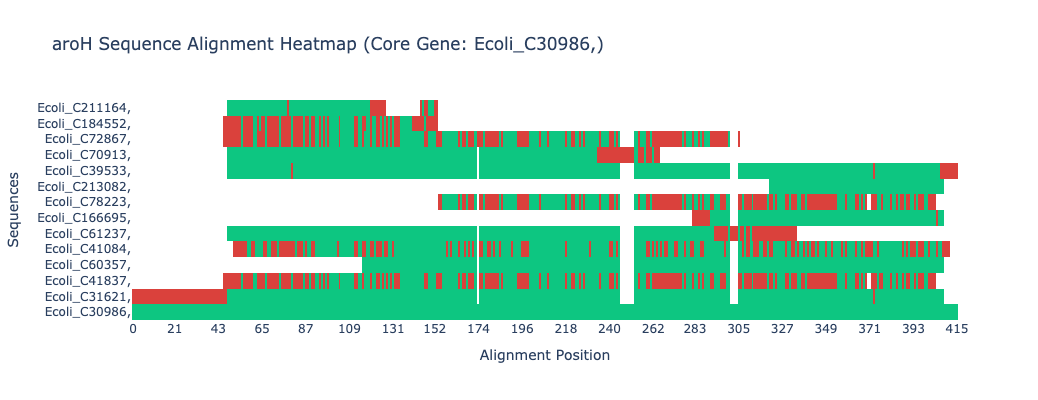

In [126]:
import plotly.graph_objects as go
import numpy as np


#path to seqs
fasta_folder = "/Users/omidard/data/deep_input/msa_test/aroH/"  # Change this to your folder containing the FASTA files
fasta_files = [os.path.join(fasta_folder, f) for f in os.listdir(fasta_folder) if f.endswith('.fasta')]

representative_sequences = [load_largest_sequence_from_fasta(fasta_file) for fasta_file in fasta_files]

# Perform MSA
alignment = perform_multiple_sequence_alignment(representative_sequences)

# Define colors for match, mismatch, and gaps
match_color = '#0dc681'  # Green for matches
mismatch_color = '#da413c'  # Red for mismatches
gap_color = 'white'  # White for gaps

# Create a custom colorscale using three distinct colors for the three conditions
custom_colorscale = [
    [0.0, gap_color],   # Gaps (0)
    [0.333, gap_color], # Gaps (0)
    [0.334, mismatch_color],  # Mismatches (1)
    [0.666, mismatch_color],  # Mismatches (1)
    [0.667, match_color],     # Matches (2)
    [1.0, match_color]        # Matches (2)
]

# Example usage
desired_order = ['Ecoli_C31621,',
                 'Ecoli_C41837,',
                 'Ecoli_C60357,',
                 'Ecoli_C41084,',
                 'Ecoli_C61237,',
                 'Ecoli_C166695,',
                 'Ecoli_C78223,',
                 'Ecoli_C213082,',
                 'Ecoli_C39533,',
                 'Ecoli_C70913,',
                 'Ecoli_C72867,',
                 'Ecoli_C184552,',
                 'Ecoli_C211164,']


gene_to_analyse = 'aroH'
visualize_alignment(gene_to_analyse, alignment, core_gene_id='Ecoli_C30986,', desired_order=desired_order, save_path="/Users/omidard/Desktop/aroH_alignment2xxx.svg", width=500, height=400)


### implementation of LoVis4u genome browser to visualize gene's neighborhood

---
visualization will be saved as a pdf file in defined destination

In [ ]:
import os
from Bio import SeqIO
import pandas as pd
import subprocess



def create_locus_annotation_table(input_gbk_folder, output_dir, target_gene="trpE", flanking_region=5000):
    """
    Creates a locus annotation table (TSV format) focusing on the neighborhood of the target gene (e.g., pdeH).
    """
    locus_data = []
    
    for gbk_file in os.listdir(input_gbk_folder):
        if gbk_file.endswith(".gbk"):
            input_path = os.path.join(input_gbk_folder, gbk_file)
            
            for record in SeqIO.parse(input_path, "genbank"):
                sequence_id = record.id
                length = len(record.seq)
                description = record.description
                
                # Find the target gene and its neighborhood
                for feature in record.features:
                    if feature.type == "CDS":
                        # Extract gene name from the product field using regex
                        product_name = feature.qualifiers.get("product", [""])[0]
                        
                        gene_name= product_name.split('] [')[0].replace('[gene=','')

                        
                        if gene_name.lower() == target_gene.lower():
                            start = int(feature.location.start)
                            end = int(feature.location.end)
                            strand = 1 if feature.strand == 1 else -1
                            upstream_start = max(0, start - flanking_region)
                            downstream_end = min(length, end + flanking_region)
                            coordinates = f"{upstream_start}:{downstream_end}:{strand}"
                            
                            # Debugging output for locus creation
                            print(f"Gene {target_gene} found in {gbk_file}: start={start}, end={end}, coordinates={coordinates}")
                            
                            # Add this record to the locus annotation table
                            locus_data.append([sequence_id, coordinates, 0, 1])
                            break  # Once target gene is found, stop checking this record.
    
    # Create output folder if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Write the locus annotation table
    locus_annotation_file = os.path.join(output_dir, "locus_annotation_table.tsv")
    locus_df = pd.DataFrame(locus_data, columns=["sequence_id", "coordinates", "order", "group"])
    locus_df.to_csv(locus_annotation_file, sep="\t", index=False)
    
    if locus_df.empty:
        print("No matching genes found. The locus annotation table is empty.")
    else:
        print(f"Locus annotation table saved to: {locus_annotation_file}")
    
    return locus_annotation_file


import os
from Bio import SeqIO
import pandas as pd
import subprocess

def filter_genbank_by_gene(input_gbk_folder, target_gene, output_gbk_folder):
    """
    Filters GenBank files to only keep records that contain the target gene.
    Saves new GenBank files with only the relevant records.
    """
    if not os.path.exists(output_gbk_folder):
        os.makedirs(output_gbk_folder)

    # Loop over each GenBank file in the folder
    for gbk_file in os.listdir(input_gbk_folder):
        if gbk_file.endswith(".gbk"):
            input_path = os.path.join(input_gbk_folder, gbk_file)
            output_path = os.path.join(output_gbk_folder, gbk_file)

            # Parse the GenBank file and filter based on target gene
            with open(input_path, 'r') as infile, open(output_path, 'w') as outfile:
                records_to_write = []
                for record in SeqIO.parse(infile, "genbank"):
                    found = False
                    for feature in record.features:
                        if feature.type == "CDS":
                            # Check if the gene or product matches the target gene
                            gene_name = feature.qualifiers.get("gene", [""])[0]
                            product_name = feature.qualifiers.get("product", [""])[0]
                            if target_gene.lower() in gene_name.lower() or target_gene.lower() in product_name.lower():
                                found = True
                                break
                    
                    # If the gene is found in the record, save the record
                    if found:
                        records_to_write.append(record)

                # Write the filtered records to the new GenBank file
                SeqIO.write(records_to_write, outfile, "genbank")

                if records_to_write:
                    print(f"Saved filtered GenBank file for {gbk_file}")
                else:
                    print(f"No matching gene found in {gbk_file}, skipped.")

def modify_genbank_annotations(input_gbk_folder, output_gbk_folder):
    """
    Modify GenBank files to replace long annotations in the CDS feature with the short gene name.
    """
    if not os.path.exists(output_gbk_folder):
        os.makedirs(output_gbk_folder)

    # Loop over each GenBank file in the folder
    for gbk_file in os.listdir(input_gbk_folder):
        if gbk_file.endswith(".gbk"):
            input_path = os.path.join(input_gbk_folder, gbk_file)
            output_path = os.path.join(output_gbk_folder, gbk_file)

            with open(input_path, 'r') as infile, open(output_path, 'w') as outfile:
                records_to_write = []
                for record in SeqIO.parse(infile, "genbank"):
                    for feature in record.features:
                        if feature.type == "CDS":
                            # Replace long annotations with the short gene name
                            gene_name = feature.qualifiers.get("gene", [""])[0]
                            if gene_name:
                                feature.qualifiers["product"] = [gene_name]
                            else:
                                # Fallback to "hypothetical protein" if no gene name
                                feature.qualifiers["product"] = ["hypothetical protein"]

                    # Add the modified record to the list
                    records_to_write.append(record)

                # Write the modified records to the new GenBank file
                SeqIO.write(records_to_write, outfile, "genbank")
                print(f"Modified GenBank file saved as {gbk_file}")


import os
from Bio import SeqIO

def add_protein_id_to_cds(input_gbk_folder, output_gbk_folder):
    """
    Adds a 'protein_id' qualifier to all CDS features in GenBank files inside the folder if not already present.
    Saves the modified GenBank file.
    """

    # Loop over each GenBank file in the input folder
    for gbk_file in os.listdir(input_gbk_folder):
        if gbk_file.endswith(".gbk"):
            input_path = os.path.join(input_gbk_folder, gbk_file)
            output_path = os.path.join(output_gbk_folder, gbk_file)

            with open(input_path, 'r') as infile, open(output_path, 'w') as outfile:
                # Parse the input GenBank file
                records_to_write = []
                for record in SeqIO.parse(infile, "genbank"):
                    for feature in record.features:
                        if feature.type == "CDS":
                            # Add 'protein_id' if it doesn't exist
                            if 'protein_id' not in feature.qualifiers:
                                # Extract the protein_id from the product field
                                product_name = feature.qualifiers.get("product", [""])[0]
                                # Assuming the gene name is at the start of the product field, extract it
                                protein_id = product_name.split('] [')[0].replace('[gene=', '')
                                feature.qualifiers['protein_id'] = [protein_id]
                    
                    # Add the modified record to the list
                    records_to_write.append(record)
        
                # Write the modified records to the output GenBank file
                SeqIO.write(records_to_write, outfile, "genbank")
                print(f"Modified GenBank file saved as {output_path}")





def run_lovis4u(genome_dir, locus_annotation_file, output_dir,group_colour='conserved'):#,label_style="description"
    """
    Runs the LoVis4u pipeline with the specified locus annotation file.
    """
    lovis4u_command = [
        "lovis4u",
        "-gb", genome_dir,  # Specify the GenBank folder
        "-hl",  # Enable homology links
        "--locus-annotation-file", locus_annotation_file,  # Use the locus annotation table
        "--reorient_loci",  # Reorient loci for homologous features
        "-o", output_dir,
        "--set-group-colour-for", group_colour,
    ]
    
    # Execute the command
    try:
        subprocess.run(lovis4u_command, check=True)
        print(f"LoVis4u analysis completed. Output saved to: {output_dir}")
    except subprocess.CalledProcessError as e:
        print(f"Error running LoVis4u: {e}")

# Example usage
input_gbk_folder = "/Users/omidard/Desktop/prokka_genomes"  # Path to folder with original GenBank files
filtered_gbk_folder = "/Users/omidard/Desktop/filtered_genomes"  # Path to save filtered GenBank files
modified_gbk_folder = "/Users/omidard/Desktop/modified_genomes"  # Path to save modified GenBank files
target_gene = "trpE"  # Gene of interest
output_directory = "/Users/omidard/Desktop/prokka_genomes/output/lovis4u_trpE_region"

# Step 1: Filter GenBank files for the target gene
filter_genbank_by_gene(input_gbk_folder, target_gene, filtered_gbk_folder)

# Step 2: Modify annotations in the filtered GenBank files
#modify_genbank_annotations(filtered_gbk_folder, modified_gbk_folder)

# Step 3: Run LoVis4u using the modified GenBank files
locus_annotation_file = create_locus_annotation_table(input_gbk_folder, output_directory)
locus_annotation_file = os.path.join(output_directory, "locus_annotation_table.tsv")  # Assuming the table is already prepared
#add_protein_id_to_cds(modified_gbk_folder, modified_gbk_folder)
run_lovis4u(filtered_gbk_folder, locus_annotation_file, output_directory,group_colour='conserved')#,label_style="description"
